# Filament Diameter Data Analysis

In [76]:
import os
import pandas as pd
import re
import numpy as np
import statsmodels.stats.multicomp as multi
from statsmodels.stats.multitest import multipletests
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
from scikit_posthocs import posthoc_dunn
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import seaborn as sns
import warnings
import gc
import itertools
import glob
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [77]:
gc.collect()

37199

In [78]:
# Global switch to control the use of rolling averages and segmenting
rolling_average_switch = True
segment_switch = False
rolling_avg_resolution = 1
down_sample_value = 1

In [79]:
directories = {
    'PETG_01': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_01_BS',
    'PETG_05': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_05_BS',
    'PLA_04': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_04_BS'
}

file_paths = {
    'PLA_02': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_02_BS.csv',
    'PLA_03': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_03_BS.csv',
    'PLA_01': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_01_BS.csv',
    'PETG_03': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_03_BS.csv',
    'PETG_04': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_04_BS.csv',
    'PETG_02': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_02_BS.csv'
}

def process_data(path, start_index=0):
    df = pd.read_csv(path, skiprows=1, low_memory=False)
    numeric_columns = ['adc_1', 'adc_2', 'diameter_1', 'diameter_2', 'length']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['counter'] = pd.to_numeric(df['counter'], errors='coerce')
    df.dropna(subset=numeric_columns + ['counter'], inplace=True)
    df['counter'] = (df['counter'] - df['counter'].iloc[0] + start_index).astype(int)
    df = df[(df['counter'] >= start_index) & (df['counter'] <= 300000)]
    
    # Shift diameter_2 measurements to align with diameter_1
    df['diameter_2'] = df['diameter_2'].shift(-48)  # Adjust this value as needed

    # Padding the last 48 steps with forward fill
    df['diameter_2'] = df['diameter_2'].ffill()

    if 'length' in df.columns and len(df['length']) > 1:
        initial_length = 1.494118
        increment = df['length'].iloc[1] - df['length'].iloc[0]
        df['length'] = initial_length + df['counter'] * increment
    return df

def process_directory(directory_path):
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    csv_files.sort()
    all_dataframes = []
    start_index = 0
    for file in csv_files:
        df = process_data(file, start_index=start_index)
        if not df.empty:
            start_index = df['counter'].max() + 1
        all_dataframes.append(df)
    return pd.concat(all_dataframes, ignore_index=True)

# Function to remove outliers from 'length' column
def remove_length_outliers(df):
    Q1 = df['length'].quantile(0.25)
    Q3 = df['length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['length'] >= lower_bound) & (df['length'] <= upper_bound)]

output_directory = r'C:\Users\David\Documents\Eric_Work\Processed_CSV_Files'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Process and store dataframes from both directories and individual files
dataframes = {}
for key, directory in directories.items():
    concatenated_df = process_directory(directory)
    output_path = os.path.join(output_directory, f'{key}_processed_data.csv')
    concatenated_df.to_csv(output_path, index=False)
    print(f'Saved {key} processed data to {output_path}')
    dataframes[key] = concatenated_df  # Add directory dataframes to the dictionary

for name, path in file_paths.items():
    dataframes[name] = process_data(path)  # Add individual file dataframes to the dictionary

# Optional: Segment Switch and Outlier Removal
if 'segment_switch' in globals() and segment_switch:
    segmented_dataframes = {}
    for name, df in dataframes.items():
        sixth = len(df) // 6
        segmented_dataframes[name] = {
            'first': remove_length_outliers(df.iloc[:sixth]),
            'second': remove_length_outliers(df.iloc[sixth:2*sixth]),
            'third': remove_length_outliers(df.iloc[2*sixth:3*sixth]),
            'fourth': remove_length_outliers(df.iloc[3*sixth:4*sixth]),
            'fifth': remove_length_outliers(df.iloc[4*sixth:5*sixth]),
            'sixth': remove_length_outliers(df.iloc[5*sixth:])
        }
    dataframes = segmented_dataframes

# Print the final DataFrames to verify
for name, df in dataframes.items():
    print(f"\n{name} DataFrame:")
    if 'segment_switch' in globals() and segment_switch:
        for segment, segment_df in df.items():
            print(f"{segment} Segment:")
            print(segment_df.tail())
    else:
        print(df.tail())
    print("-" * 40)

Saved PETG_01 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PETG_01_processed_data.csv
Saved PETG_05 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PETG_05_processed_data.csv
Saved PLA_04 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PLA_04_processed_data.csv

PETG_01 DataFrame:
        counter  adc_1  adc_2  diameter_1  diameter_2         length
189363   189675   2592   2637    1.741213    1.782081  283398.258822
189364   189676   2590   2641    1.743731    1.782081  283399.752940
189365   189677   2586   2638    1.748768    1.782081  283401.247058
189366   189678   2590   2636    1.743731    1.782081  283402.741175
189367   189679   2594   2637    1.738694    1.782081  283404.235293
----------------------------------------

PETG_05 DataFrame:
        counter   adc_1   adc_2  diameter_1  diameter_2         length
213512   213511  3649.0  3895.0    0.410208     0.45282  319012.047057
213513   213512  3648.0

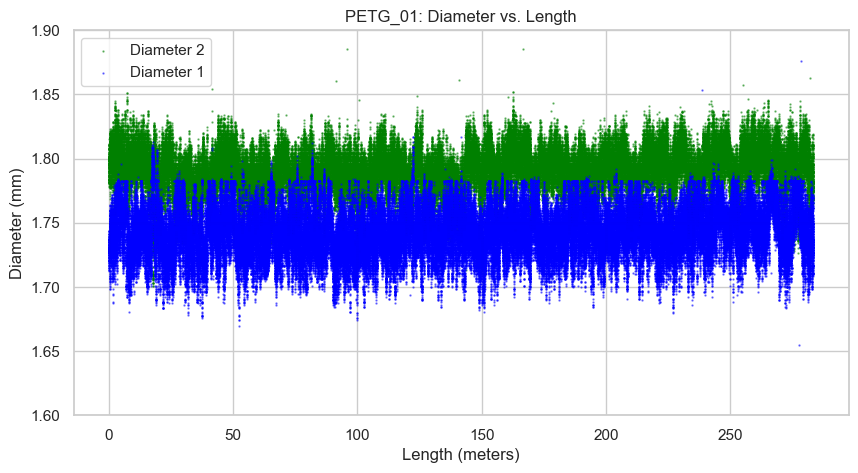

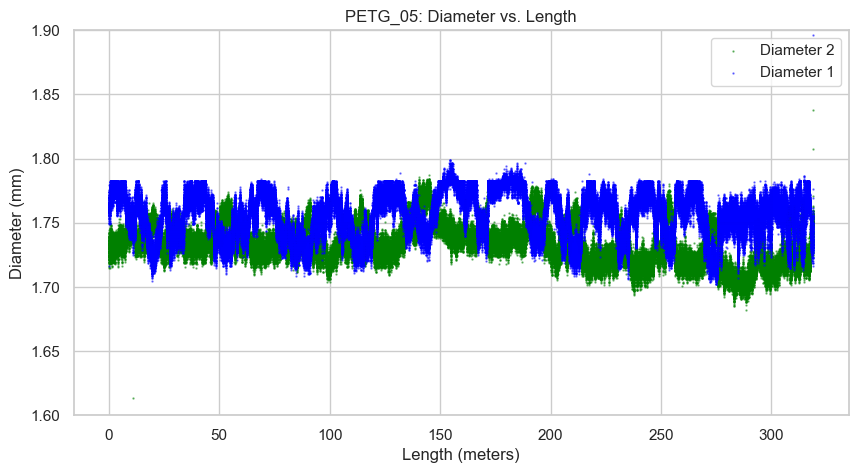

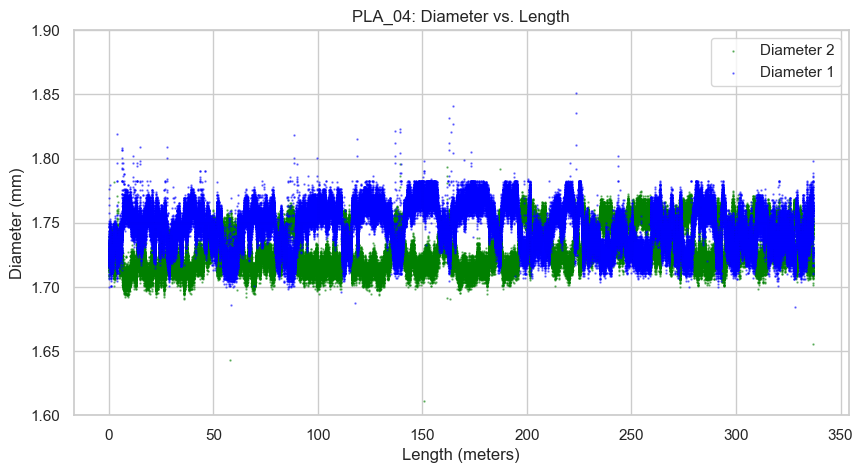

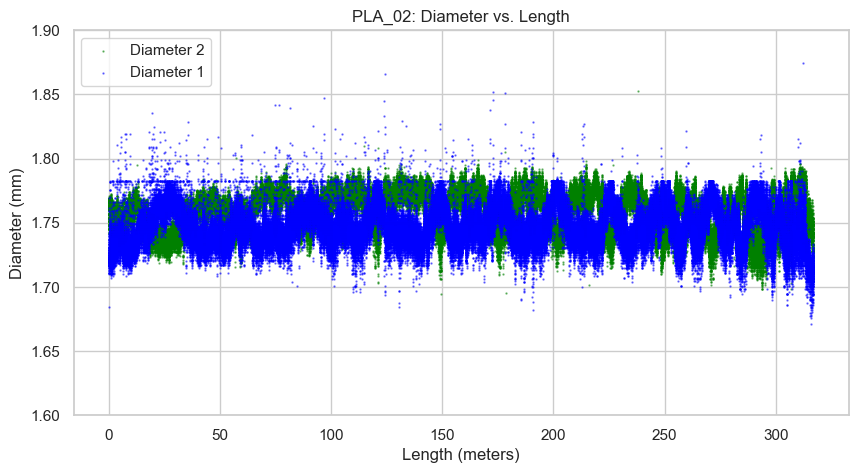

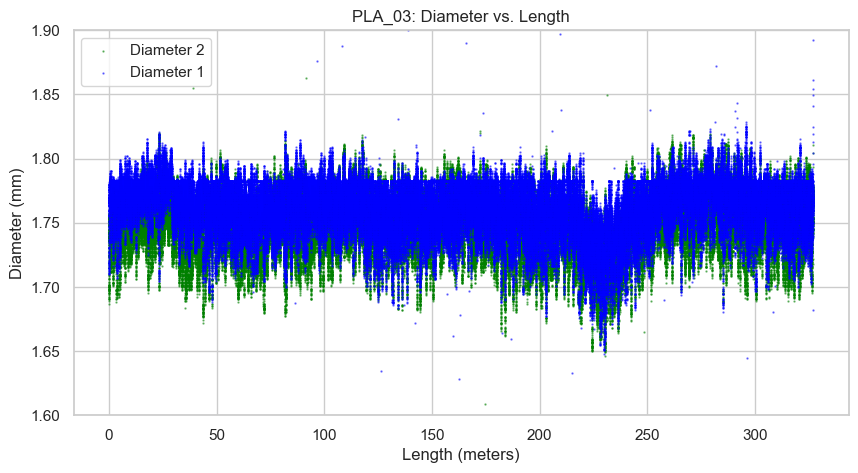

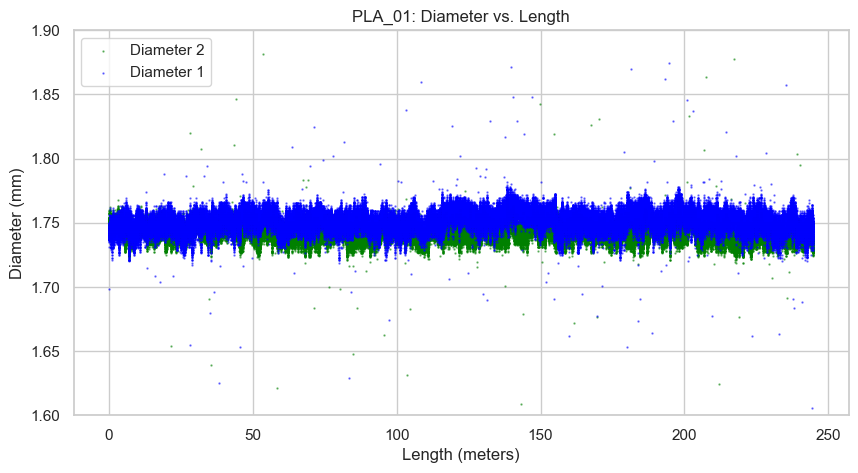

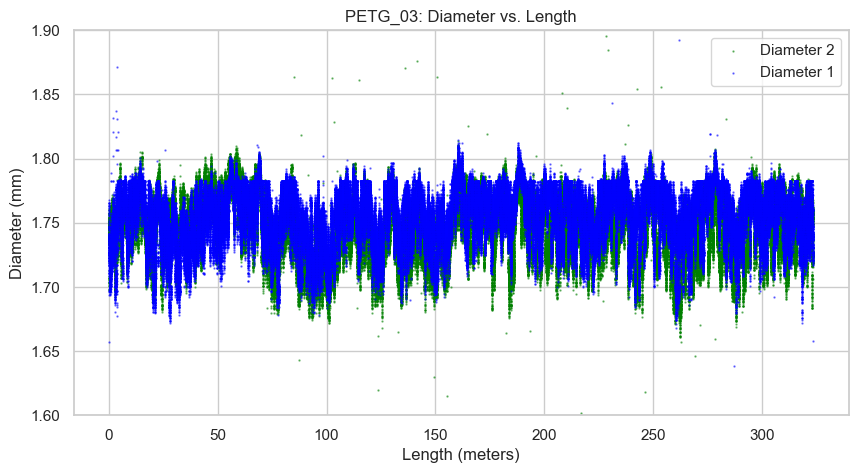

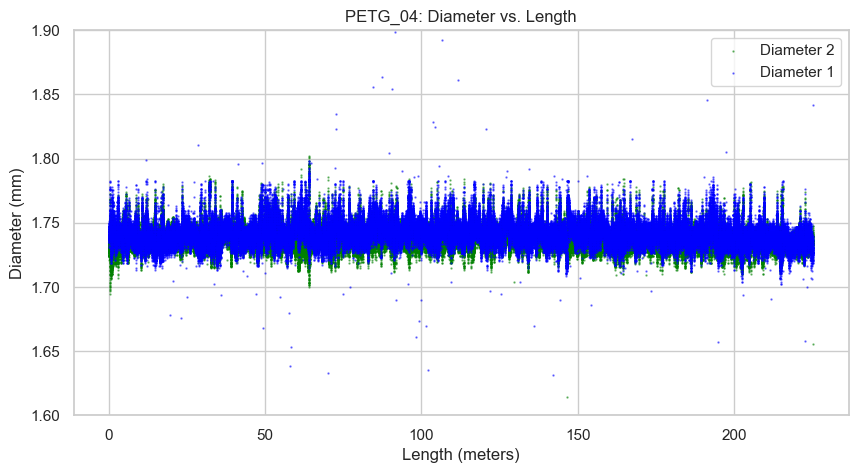

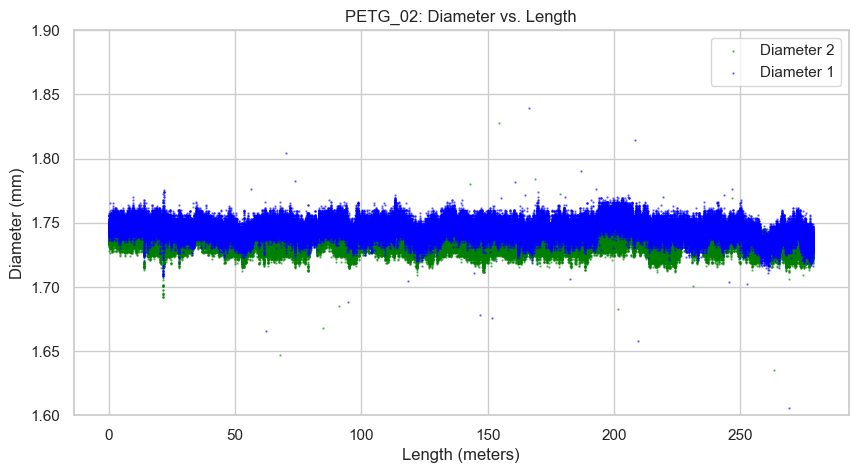

In [80]:
def plot_diameters(df, title):
    # Convert length from mm to meters
    df['length_meters'] = df['length'] / 1000  # Adding a new column to keep the original data intact

    plt.figure(figsize=(10, 5))
    plt.scatter(df['length_meters'], df['diameter_2'], alpha=0.5, label='Diameter 2', color='green', s=0.5)
    plt.scatter(df['length_meters'], df['diameter_1'], alpha=0.5, label='Diameter 1', color='blue', s=0.5)
    
    plt.title(title)
    plt.xlabel('Length (meters)')  # Update label to meters
    plt.ylabel('Diameter (mm)')
    plt.legend()
    plt.grid(True)
    plt.ylim(1.6, 1.9)
    plt.show()

if segment_switch:
    for name, segments in dataframes.items():
        for segment_name, segment_df in segments.items():
            plot_diameters(segment_df, f'{name} - {segment_name}: Diameter vs. Length')
else:
    for name, df in dataframes.items():
        plot_diameters(df, f'{name}: Diameter vs. Length')

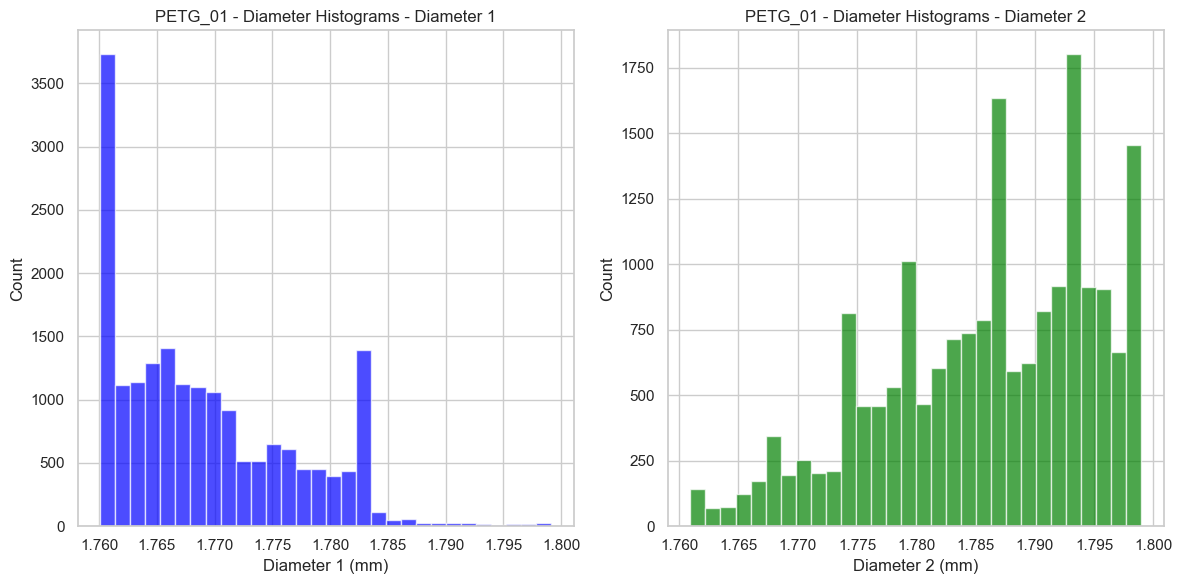

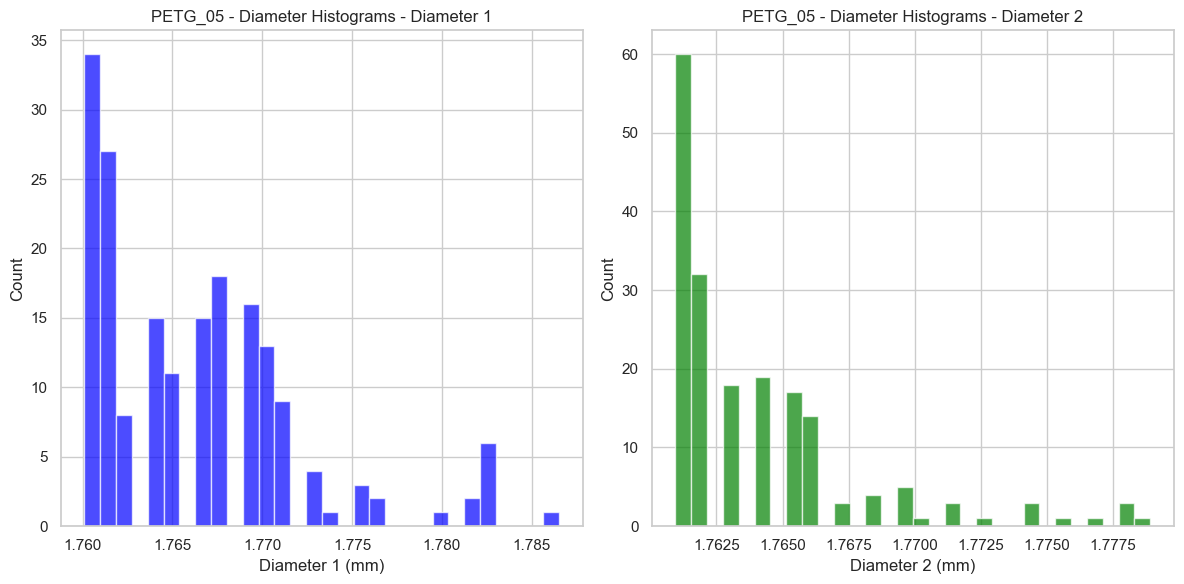

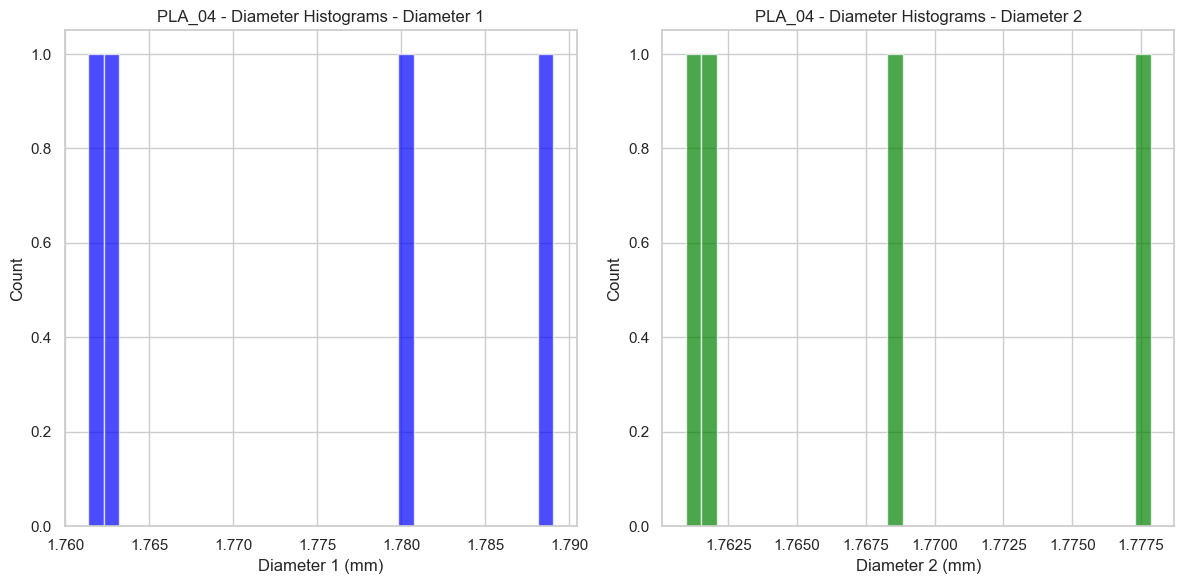

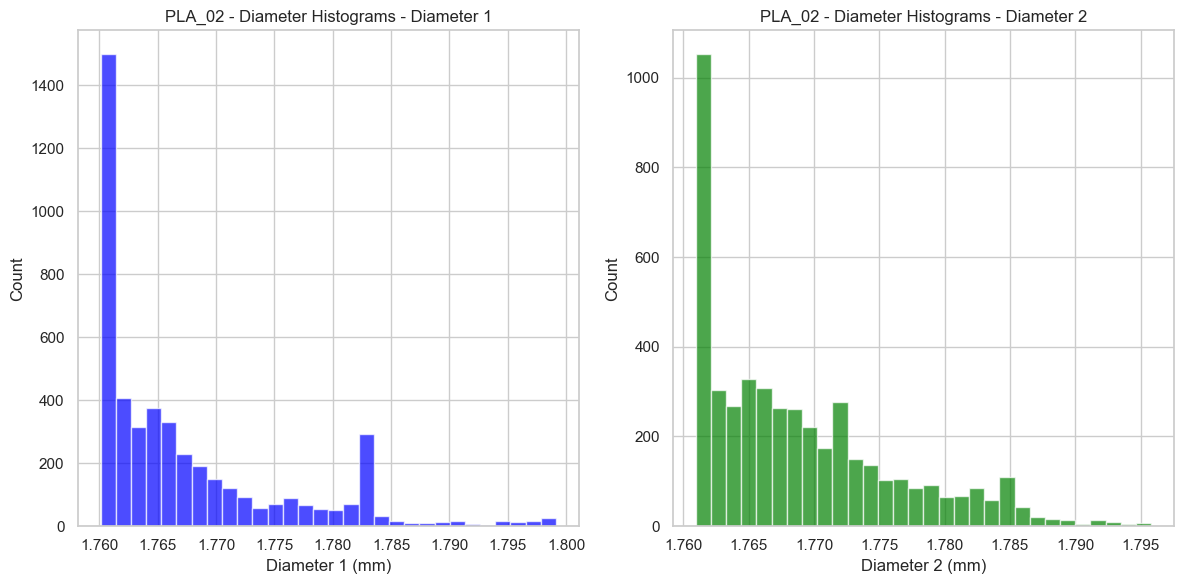

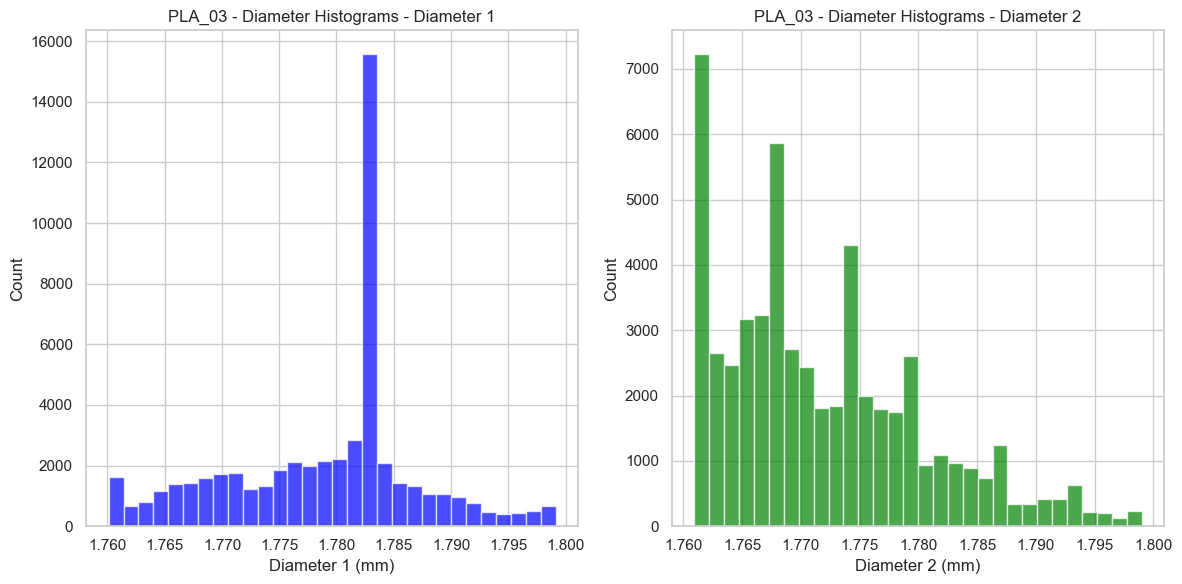

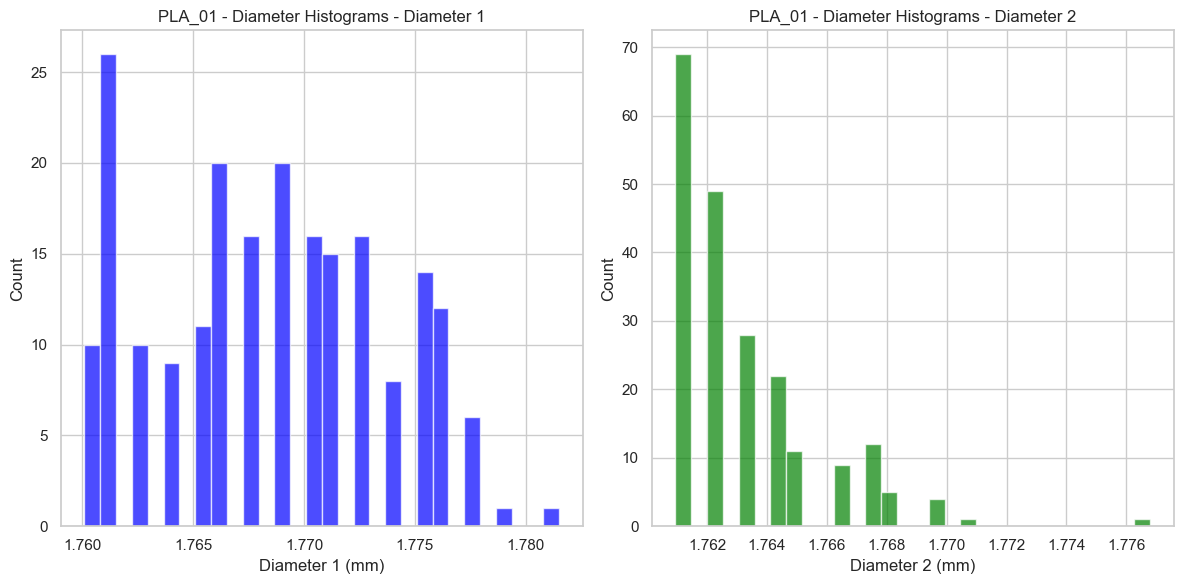

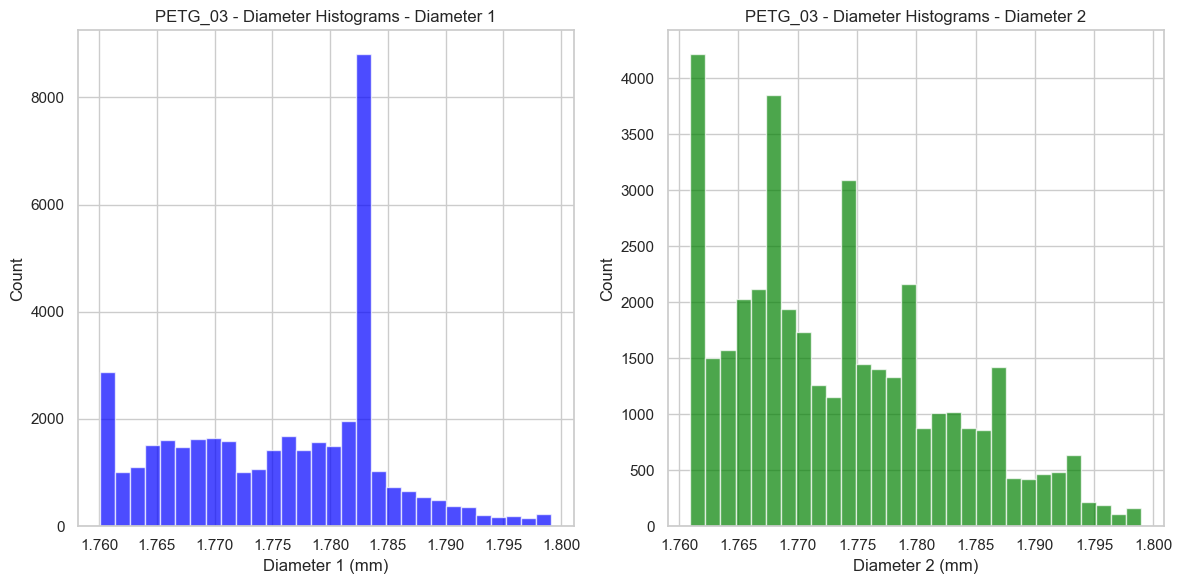

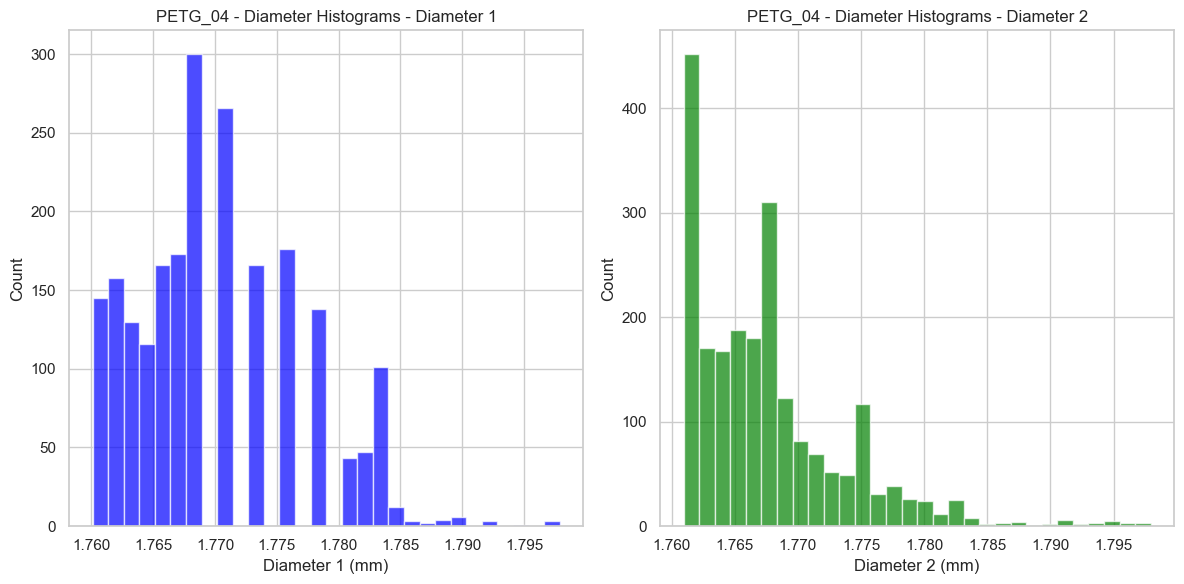

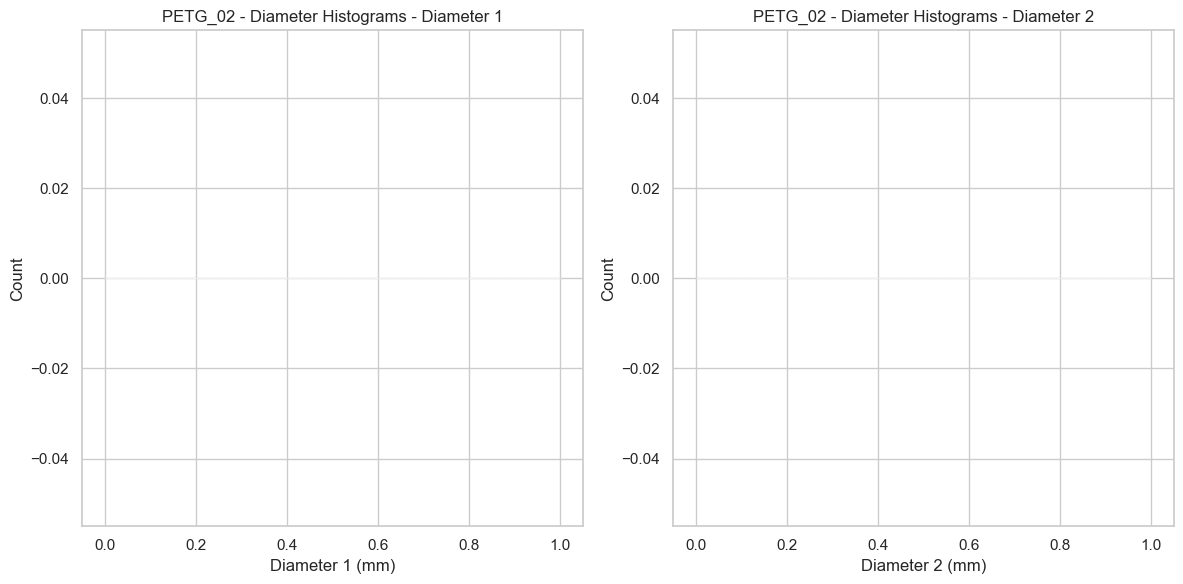

In [53]:
def plot_diameter_histograms(df, title):
    # Filter the DataFrame for diameters between 1.76 and 1.8 mm
    filtered_df = df[(df['diameter_1'] >= 1.76) & (df['diameter_1'] <= 1.8) & (df['diameter_2'] >= 1.76) & (df['diameter_2'] <= 1.8)]
    
    plt.figure(figsize=(12, 6))
    
    # Plot histogram for Diameter 1
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.hist(filtered_df['diameter_1'], bins=30, color='blue', alpha=0.7)
    plt.title(f'{title} - Diameter 1')
    plt.xlabel('Diameter 1 (mm)')
    plt.ylabel('Count')
    plt.grid(True)
    
    # Plot histogram for Diameter 2
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.hist(filtered_df['diameter_2'], bins=30, color='green', alpha=0.7)
    plt.title(f'{title} - Diameter 2')
    plt.xlabel('Diameter 2 (mm)')
    plt.ylabel('Count')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Check if the segment_switch is set and plot accordingly
segment_switch = False  # Set this according to your application's logic

if segment_switch:
    for name, segments in dataframes.items():
        for segment_name, segment_df in segments.items():
            plot_diameter_histograms(segment_df, f'{name} - {segment_name}')
else:
    for name, df in dataframes.items():
        plot_diameter_histograms(df, f'{name} - Diameter Histograms')

# CAE of difference between diameter 1 and diameter 2 (Diameter Difference)

C:\Users\David\AppData\Local\Temp\ipykernel_1456\3805703412.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



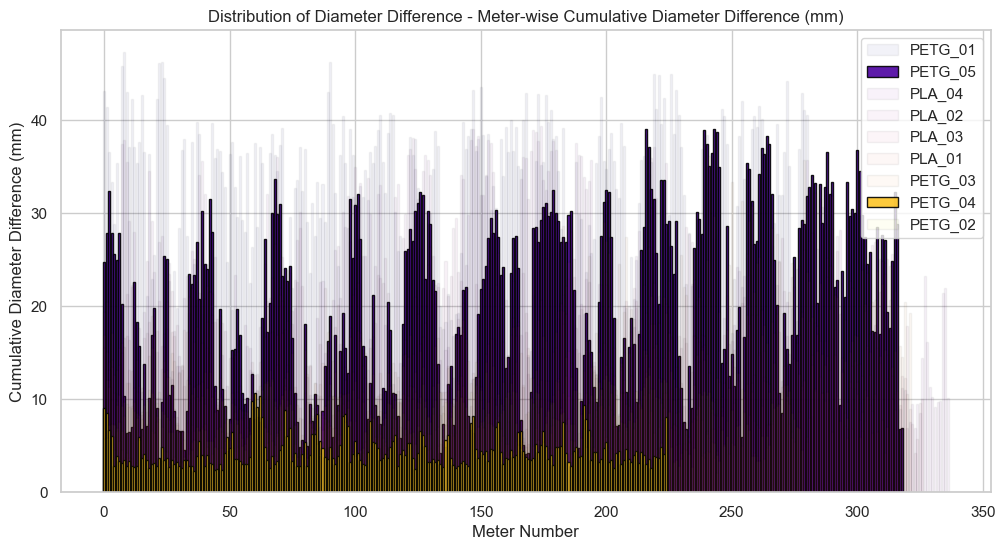

In [54]:
def calculate_meter_wise_cumulative_diameter_difference(df, measurement_increment, meter_length=1000):
    if 'diameter_difference' not in df.columns:
        # If diameter_difference does not exist, calculate it
        df['diameter_difference'] = np.abs(df['diameter_1'] - df['diameter_2'])
    
    meters_per_measurement = measurement_increment / meter_length
    measurements_per_meter = max(1, int(1 / meters_per_measurement))  # Ensure at least one measurement per meter
    total_measurements = len(df)
    full_meters = total_measurements // measurements_per_meter

    meter_cumulative_diameter_difference = []
    for i in range(full_meters):
        start_idx = i * measurements_per_meter
        end_idx = start_idx + measurements_per_meter
        meter_df = df.iloc[start_idx:end_idx]
        cumulative_sum = meter_df['diameter_difference'].cumsum().iloc[-1]
        meter_cumulative_diameter_difference.append(cumulative_sum)

    # Handling any leftover measurements that don't make up a full meter
    if total_measurements % measurements_per_meter != 0:
        start_idx = full_meters * measurements_per_meter
        meter_df = df.iloc[start_idx:]
        cumulative_sum = meter_df['diameter_difference'].cumsum().iloc[-1]
        meter_cumulative_diameter_difference.append(cumulative_sum)

    return meter_cumulative_diameter_difference

def plot_diameter_difference_and_cumulative(dataframes, title, measurement_increment, emphasize_groups=None):
    if emphasize_groups is None:
        emphasize_groups = []

    color_map = plt.cm.get_cmap('plasma', len(dataframes))  # Generate a color map for unique colors
    fig, ax = plt.subplots(figsize=(12, 6))
    
    color_idx = 0
    for name, df in dataframes.items():
        if isinstance(df, pd.DataFrame):
            # Check if diameter_difference column needs to be computed
            if 'diameter_difference' not in df.columns:
                df['diameter_difference'] = np.abs(df['diameter_1'] - df['diameter_2'])

            cumulative_diameter_difference = calculate_meter_wise_cumulative_diameter_difference(df, measurement_increment)
            
            # Set the alpha value for emphasis or fading
            alpha_value = 0.9 if name in emphasize_groups else 0.05  # Full opacity for emphasized groups, faded for others
            
            # Adjust the width of the bars to prevent overlapping
            ax.bar(range(len(cumulative_diameter_difference)), cumulative_diameter_difference, width=0.8,
                   color=color_map(color_idx), edgecolor='black', label=f'{name}', alpha=alpha_value)
            color_idx += 1
    
    ax.set_xlabel('Meter Number')
    ax.set_ylabel('Cumulative Diameter Difference (mm)')
    ax.set_title(f'{title} - Meter-wise Cumulative Diameter Difference (mm)')
    ax.legend()  # Show legend to identify groups
    plt.show()

measurement_increment = 1.49  # Adjust as needed

# Specify groups to emphasize
emphasize_groups = ['PETG_05', 'PETG_04']

# Assuming dataframes is a dictionary of DataFrames with necessary columns
plot_diameter_difference_and_cumulative(dataframes, 'Distribution of Diameter Difference', measurement_increment, emphasize_groups)

# Periodicity

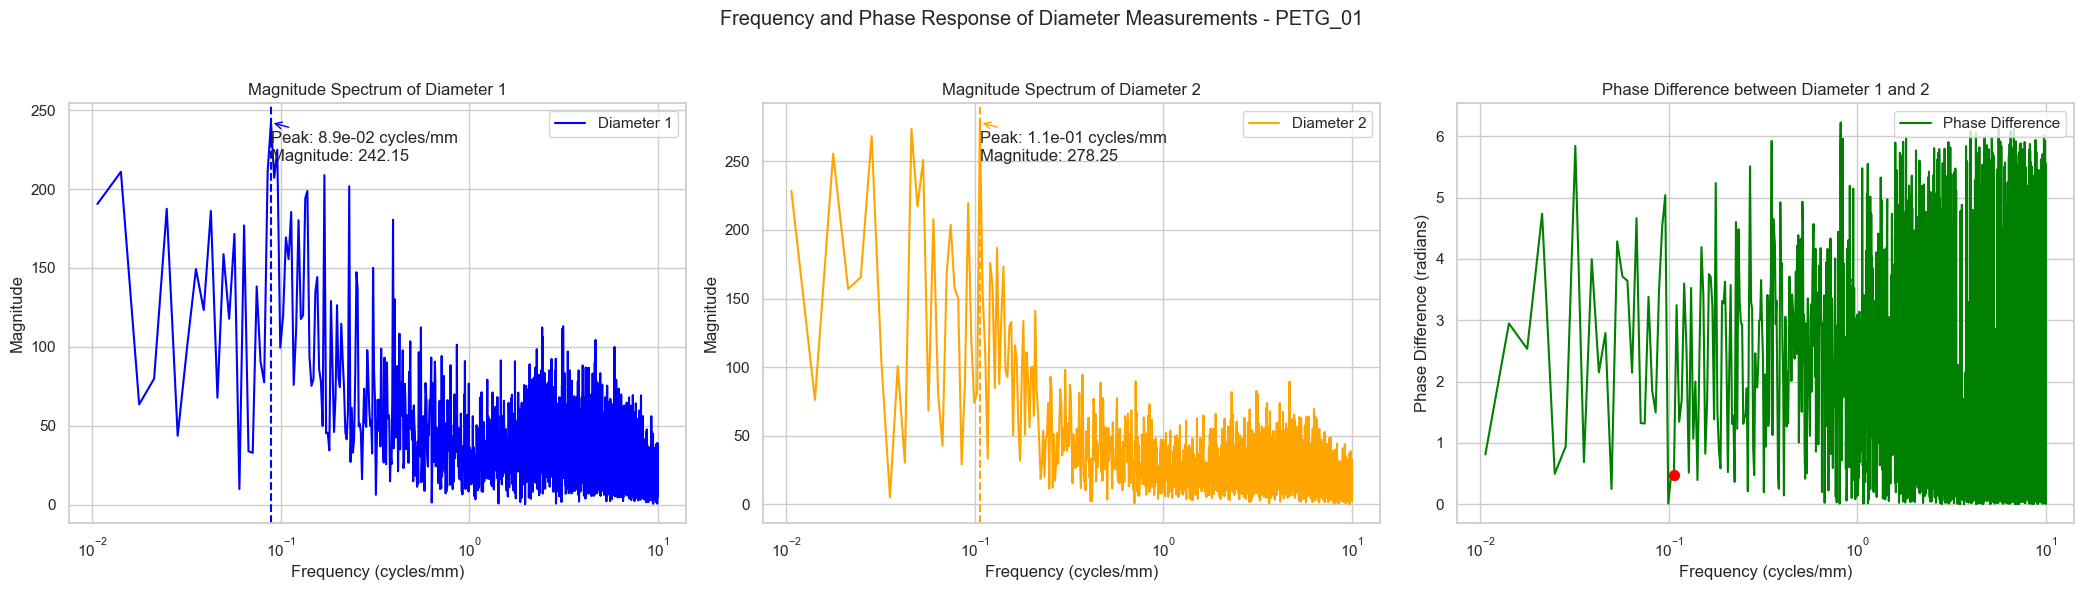

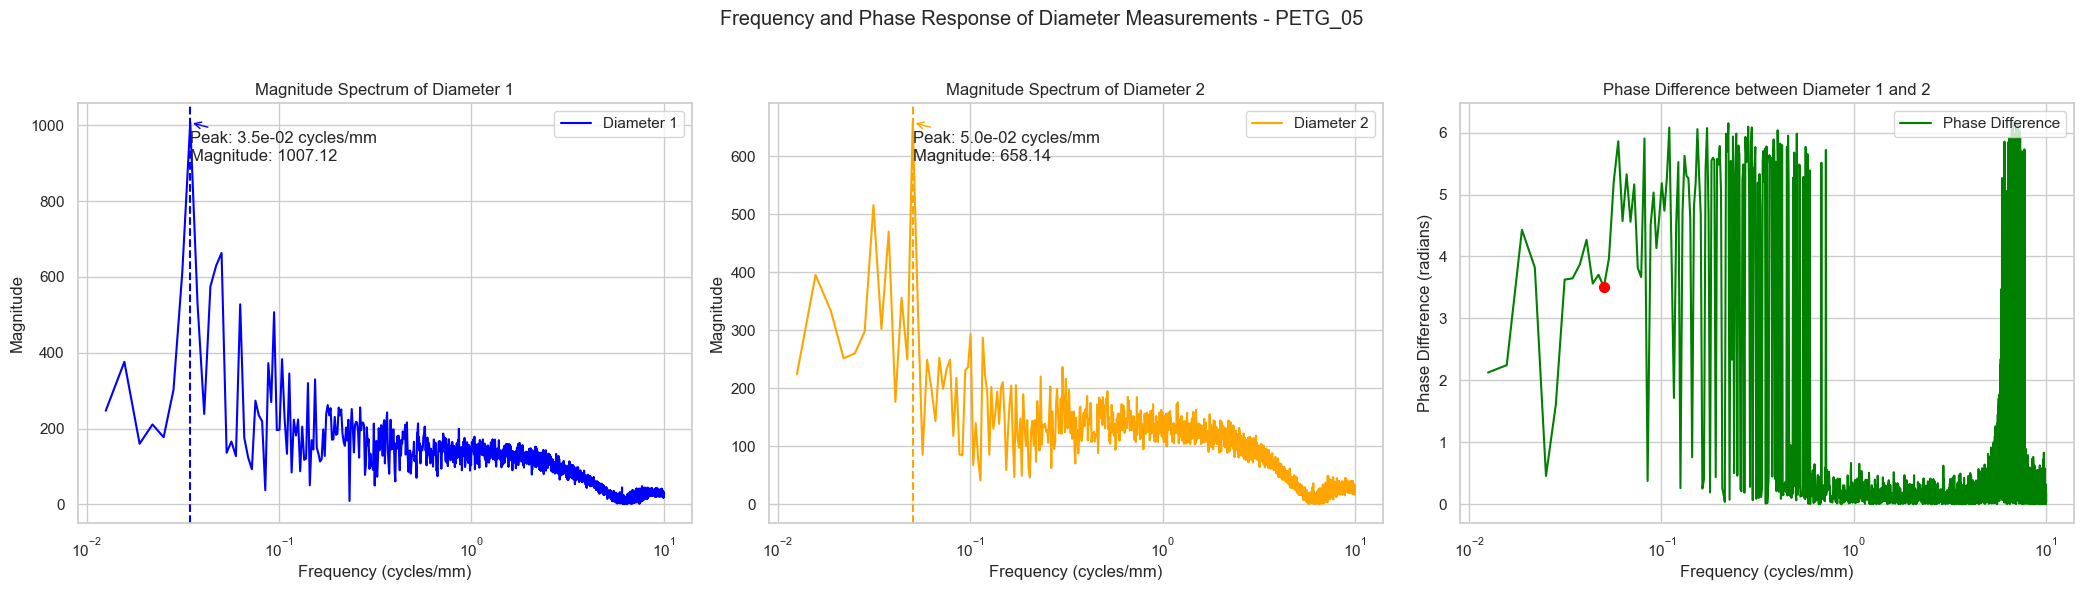

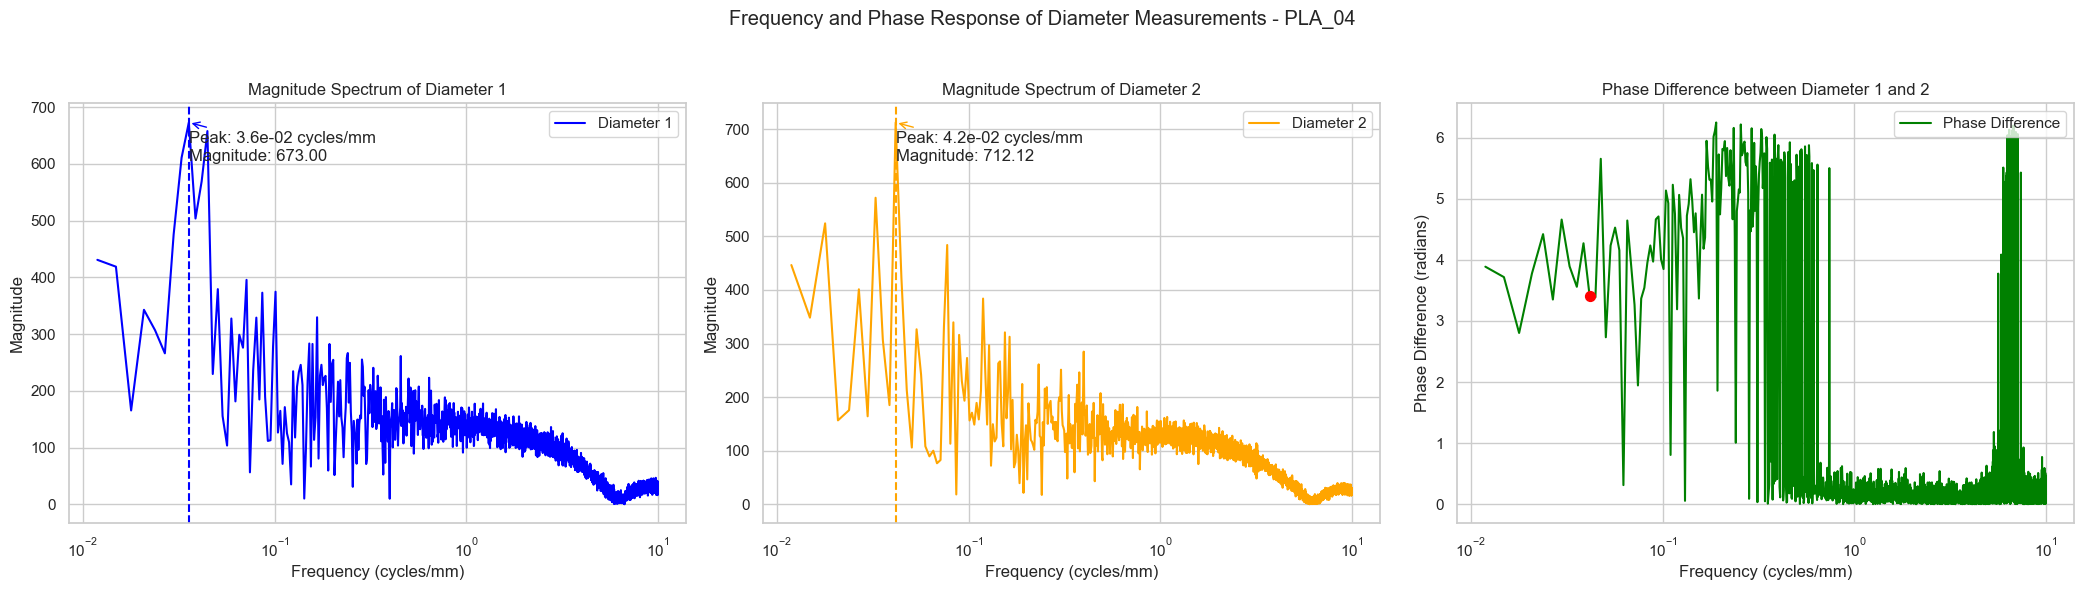

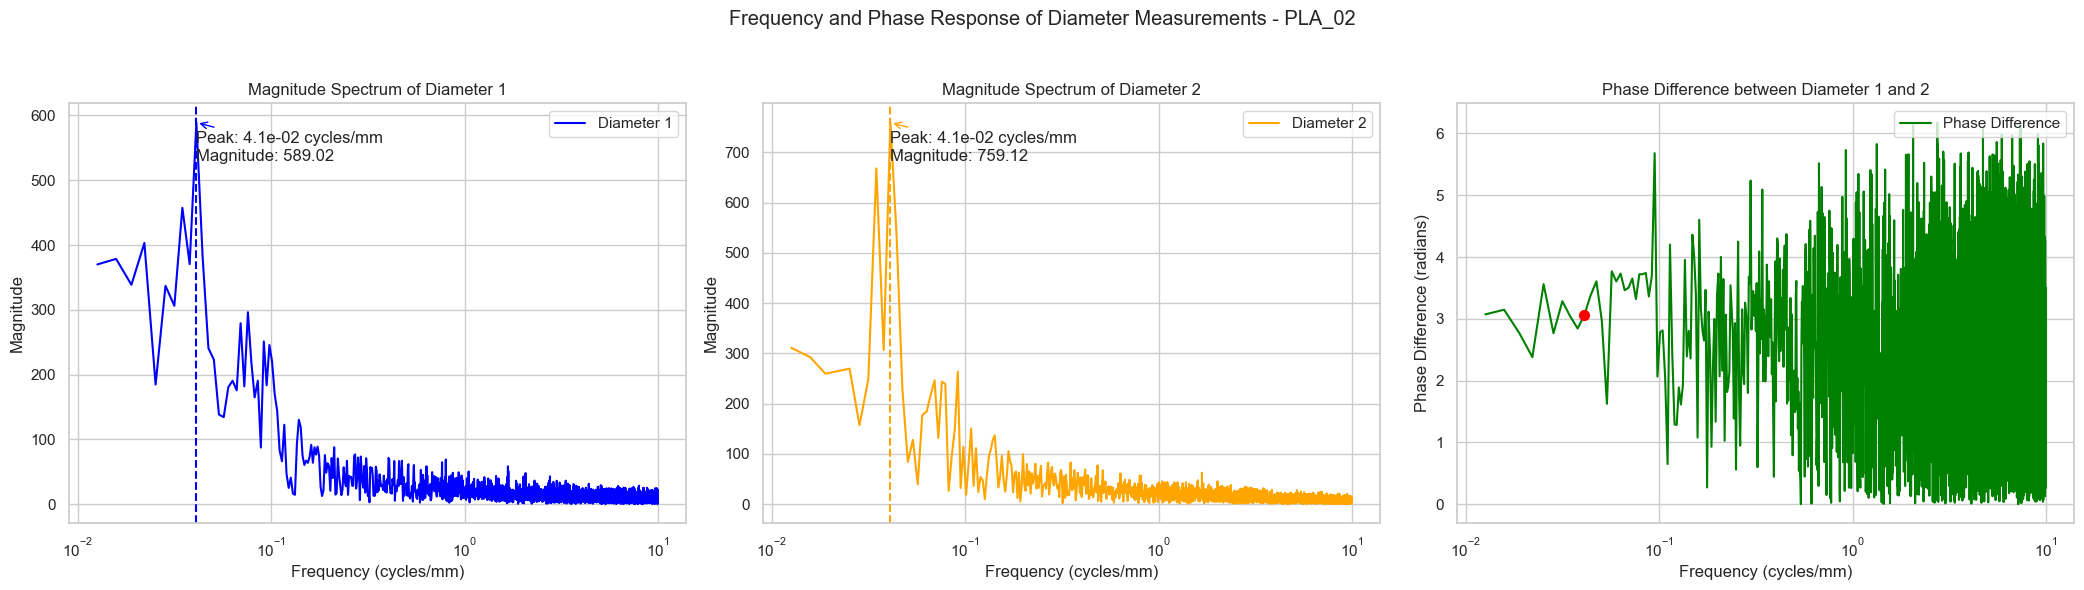

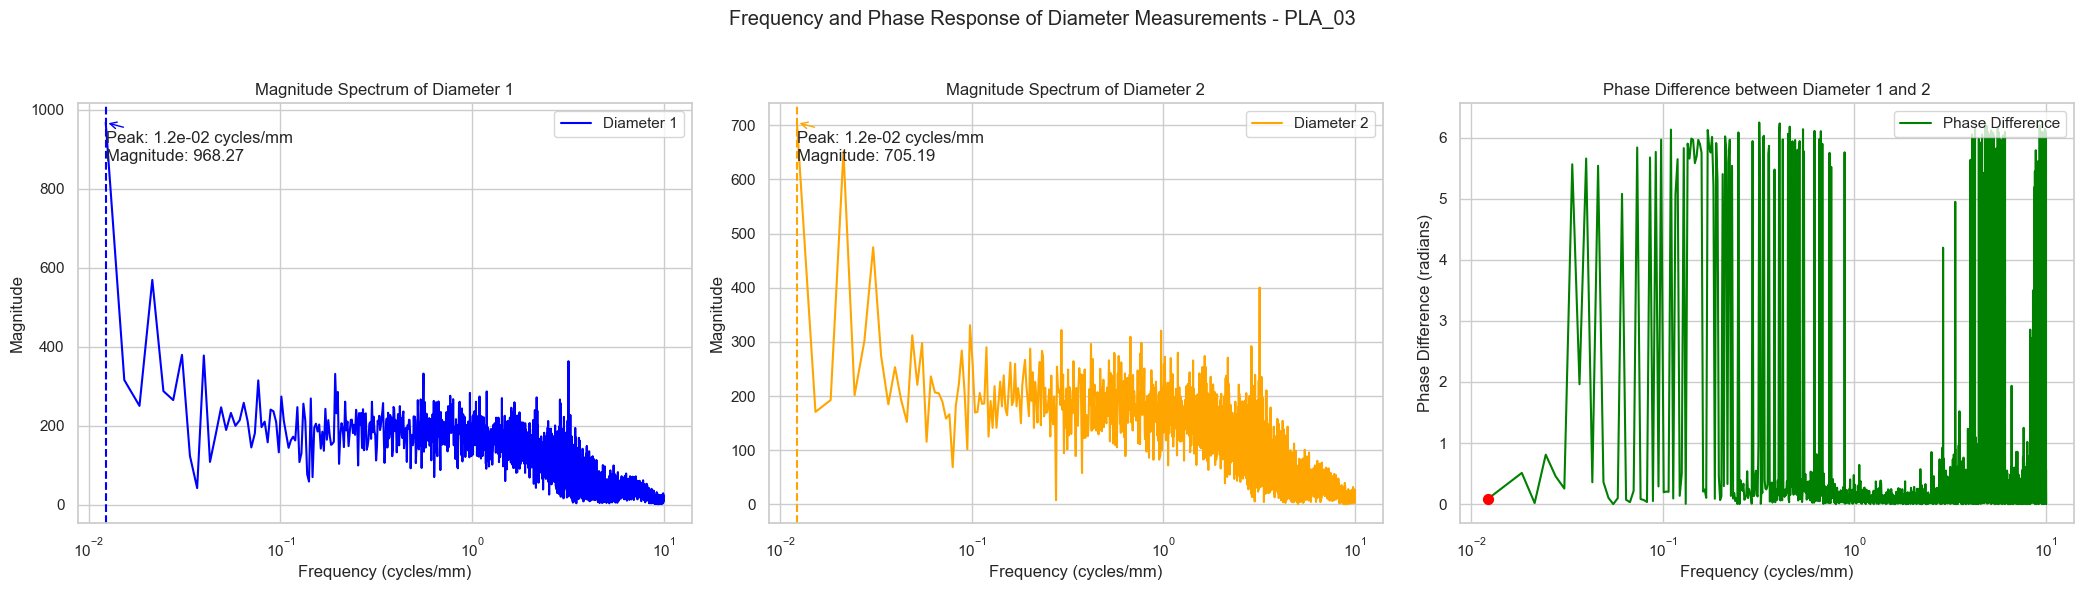

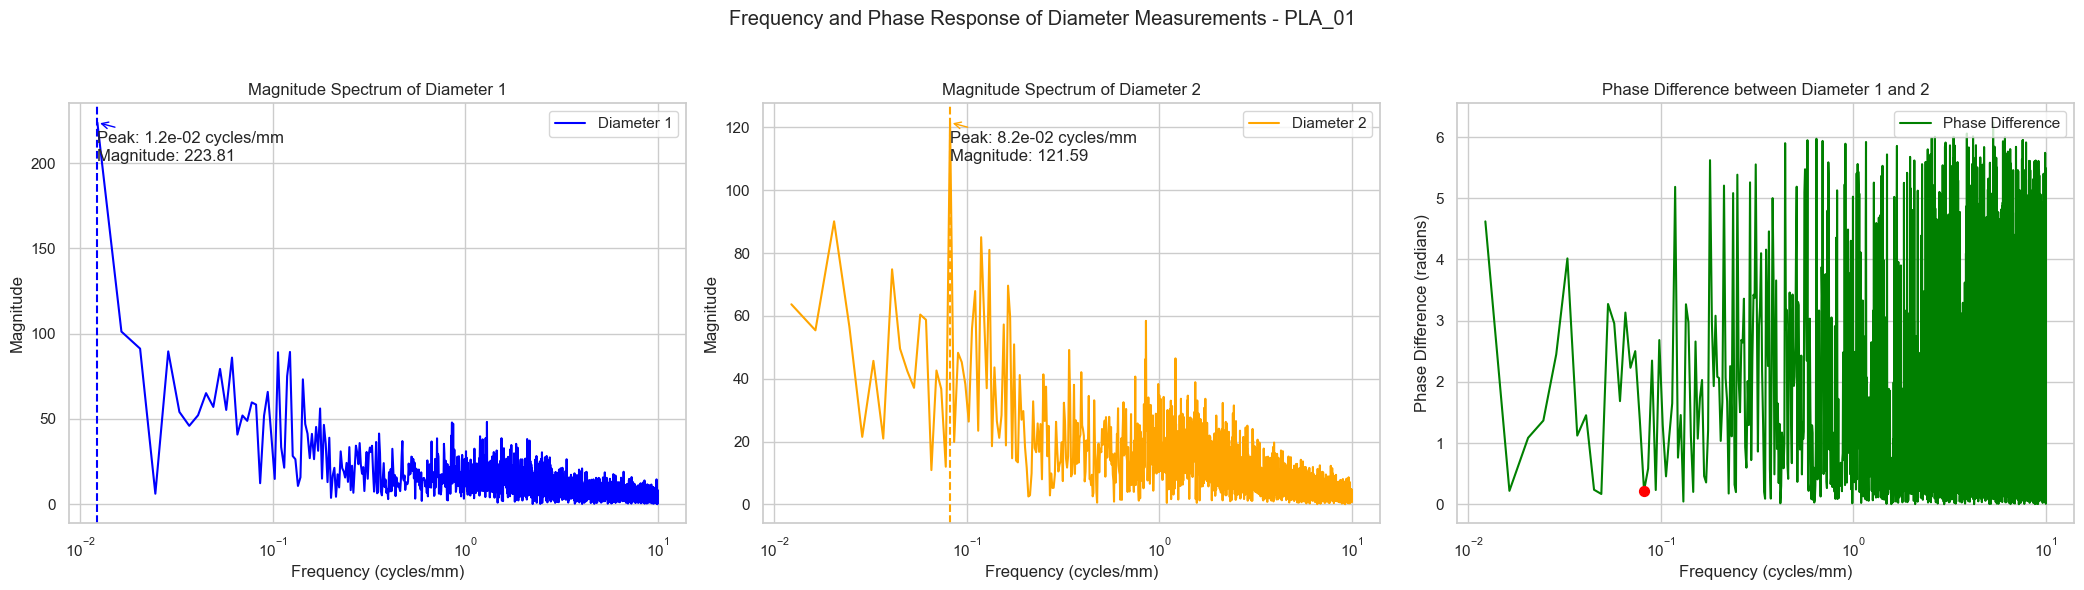

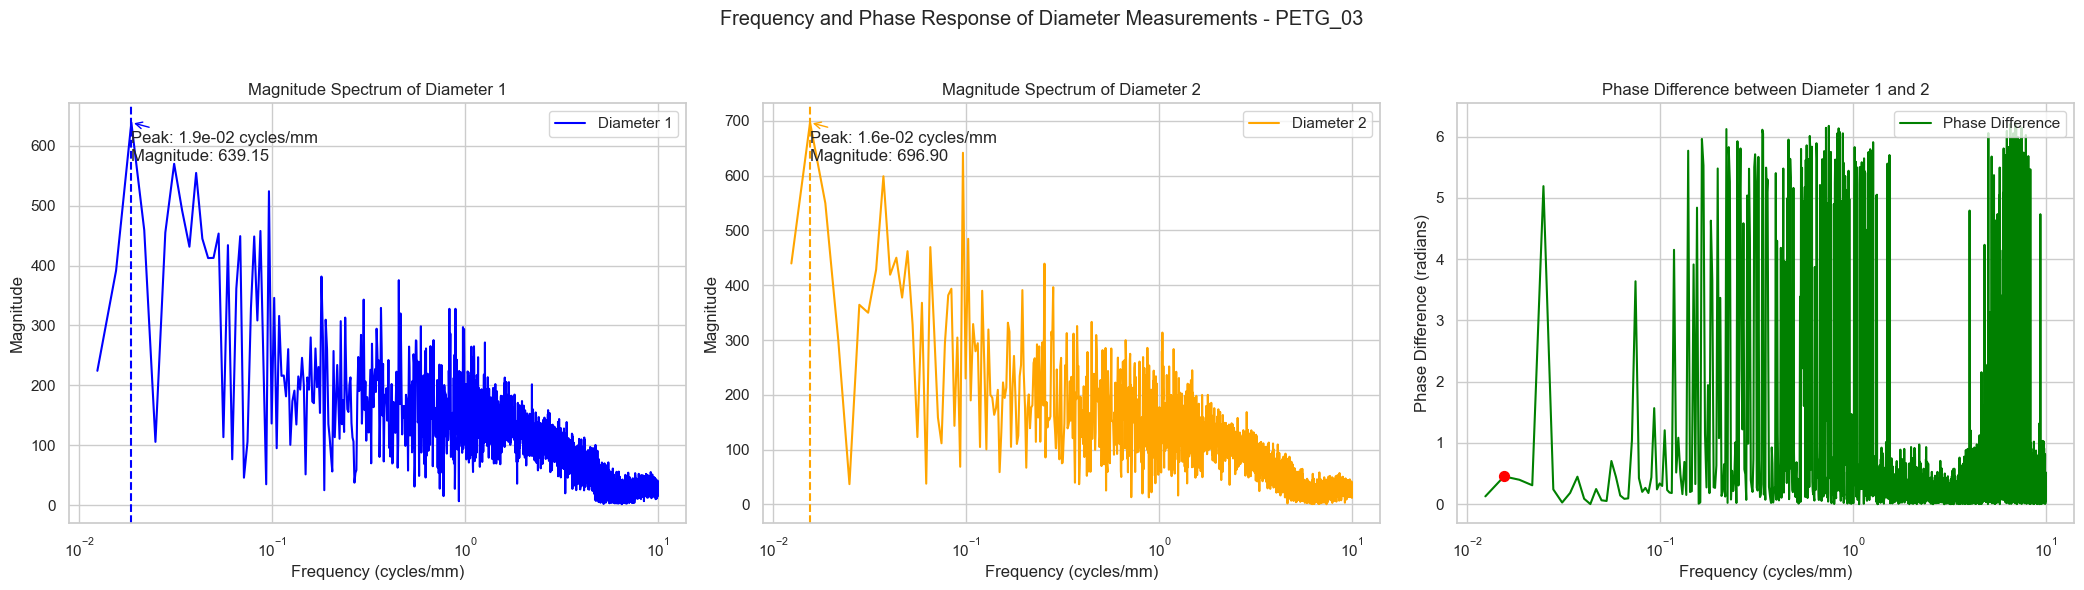

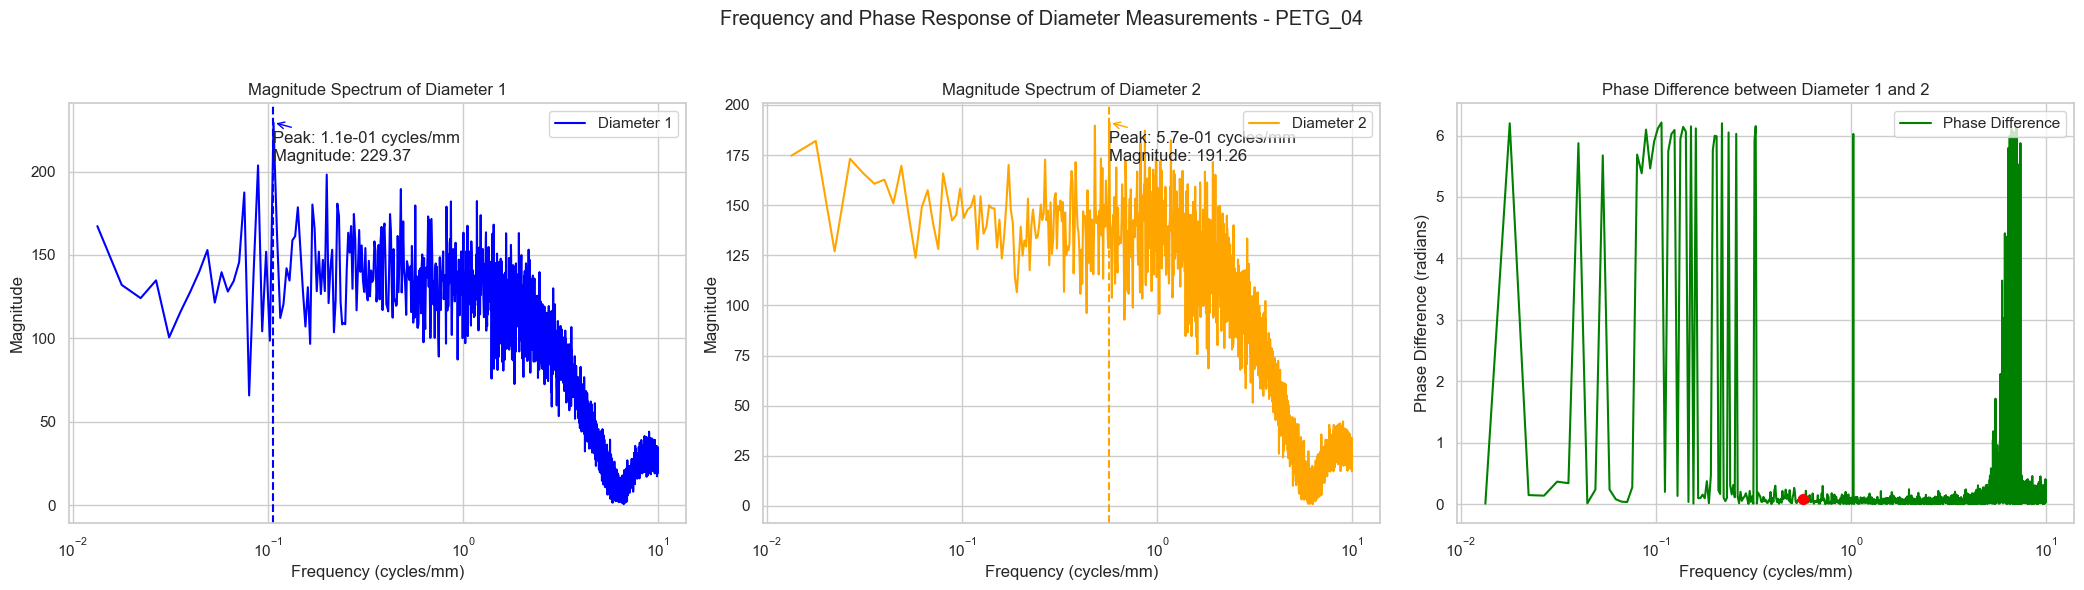

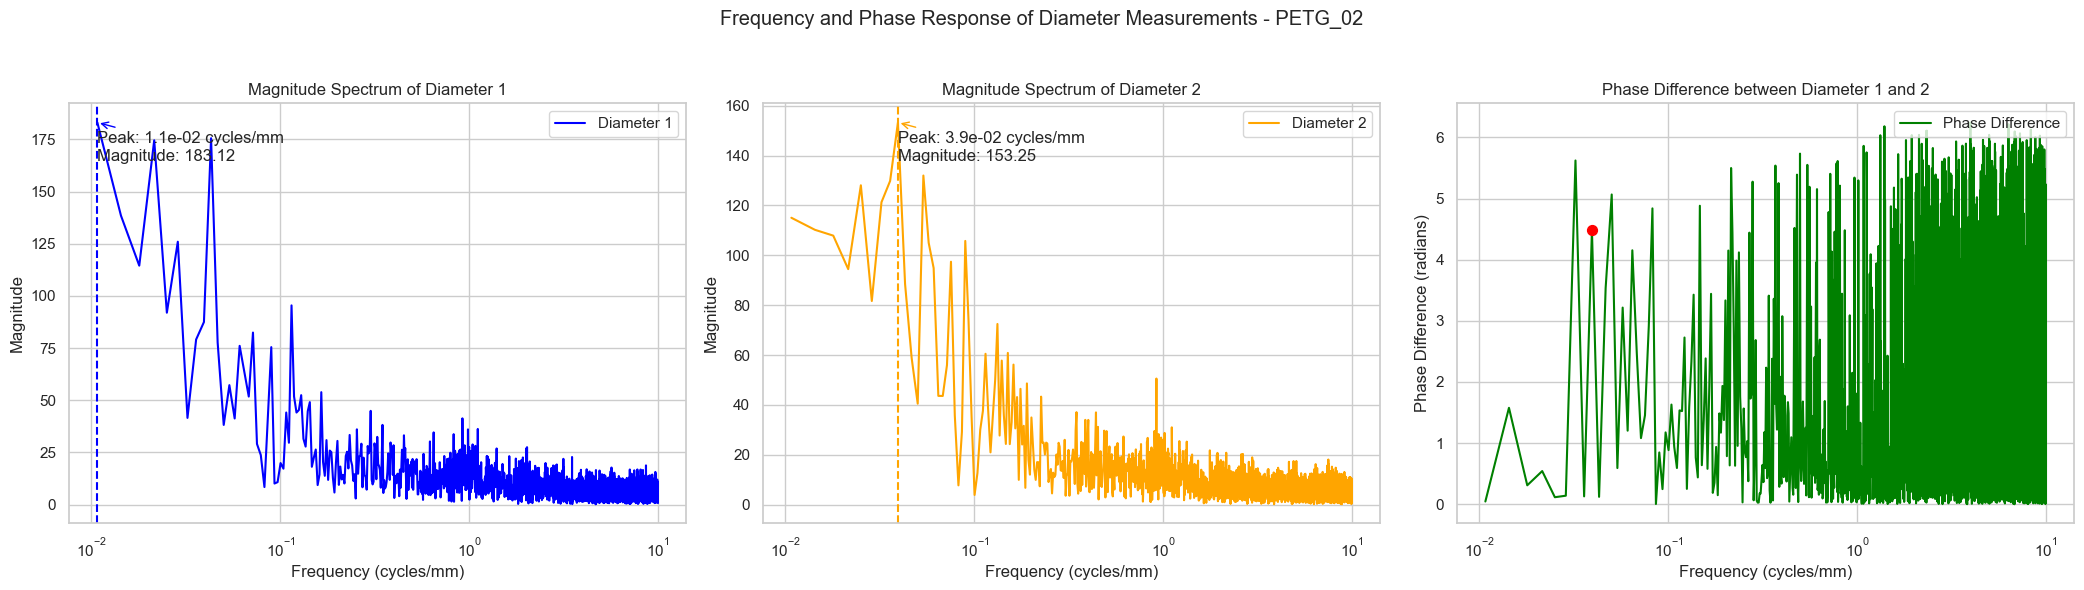

In [55]:
def analyze_periodicity_and_phase_with_labels(df, title_suffix=''):
    if 'diameter_1' not in df.columns or 'diameter_2' not in df.columns:
        print("Necessary columns are missing in the DataFrame.")
        return

    fft_diameter1 = np.fft.fft(df['diameter_1'].dropna())
    fft_diameter2 = np.fft.fft(df['diameter_2'].dropna())
    freq = np.fft.fftfreq(len(fft_diameter1), d=1.49)  # d is now in millimeters
    freq_in_cycles_per_meter = freq * 1000  # Convert frequency unit to cycles per meter

    positive_freq_indices = freq > 0
    freq_in_cycles_per_meter = freq_in_cycles_per_meter[positive_freq_indices]
    fft_diameter1 = fft_diameter1[positive_freq_indices]
    fft_diameter2 = fft_diameter2[positive_freq_indices]

    # Extended frequency range for analysis
    range_indices = (freq_in_cycles_per_meter > 1e-2) & (freq_in_cycles_per_meter <= 1e1)
    freq_range = freq_in_cycles_per_meter[range_indices]
    magnitude_d1_range = np.abs(fft_diameter1[range_indices])
    magnitude_d2_range = np.abs(fft_diameter2[range_indices])
    phase_d1_range = np.angle(fft_diameter1[range_indices])
    phase_d2_range = np.angle(fft_diameter2[range_indices])
    phase_difference = np.abs(phase_d1_range - phase_d2_range)

    plot_frequency_response(freq_range, magnitude_d1_range, magnitude_d2_range, phase_difference, 'Frequency and Phase Response of Diameter Measurements' + title_suffix)

def plot_frequency_response(freq_range, magnitude_d1_range, magnitude_d2_range, phase_difference, title):
    plt.figure(figsize=(21, 6))
    
    # Plotting diameter 1
    ax1 = plt.subplot(131)
    ax1.semilogx(freq_range, magnitude_d1_range, label='Diameter 1', color='blue')
    peaks_indices = np.where(magnitude_d1_range == np.max(magnitude_d1_range))[0]
    for peak_index in peaks_indices:
        peak_freq = freq_range[peak_index]
        ax1.axvline(x=peak_freq, color='blue', linestyle='--')
        ax1.annotate(f'Peak: {peak_freq:.1e} cycles/mm\nMagnitude: {magnitude_d1_range[peak_index]:.2f}',
                     xy=(peak_freq, magnitude_d1_range[peak_index]), xytext=(peak_freq, magnitude_d1_range[peak_index]*0.9),
                     textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue'))
    ax1.set_title('Magnitude Spectrum of Diameter 1')
    ax1.set_xlabel('Frequency (cycles/mm)')
    ax1.set_ylabel('Magnitude')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plotting diameter 2
    ax2 = plt.subplot(132)
    ax2.semilogx(freq_range, magnitude_d2_range, label='Diameter 2', color='orange')
    peaks_indices = np.where(magnitude_d2_range == np.max(magnitude_d2_range))[0]
    for peak_index in peaks_indices:
        peak_freq = freq_range[peak_index]
        ax2.axvline(x=peak_freq, color='orange', linestyle='--')
        ax2.annotate(f'Peak: {peak_freq:.1e} cycles/mm\nMagnitude: {magnitude_d2_range[peak_index]:.2f}',
                     xy=(peak_freq, magnitude_d2_range[peak_index]), xytext=(peak_freq, magnitude_d2_range[peak_index]*0.9),
                     textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='orange'))
    ax2.set_title('Magnitude Spectrum of Diameter 2')
    ax2.set_xlabel('Frequency (cycles/mm)')
    ax2.set_ylabel('Magnitude')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    # Plotting phase difference
    ax3 = plt.subplot(133)
    ax3.semilogx(freq_range, phase_difference, label='Phase Difference', color='green')
    ax3.scatter(freq_range[peaks_indices], phase_difference[peaks_indices], color='red', zorder=5, s=50)  # Enhanced visibility
    ax3.set_title('Phase Difference between Diameter 1 and 2')
    ax3.set_xlabel('Frequency (cycles/mm)')
    ax3.set_ylabel('Phase Difference (radians)')
    ax3.legend(loc='upper right')
    ax3.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

if 'segment_switch' in globals() and segment_switch:
    for name, segments in dataframes.items():
        for segment_name, segment_df in segments.items():
            analyze_periodicity_and_phase_with_labels(segment_df, title_suffix=f' - {name} {segment_name}')
else:
    for name, df in dataframes.items():
        analyze_periodicity_and_phase_with_labels(df, title_suffix=f' - {name}')

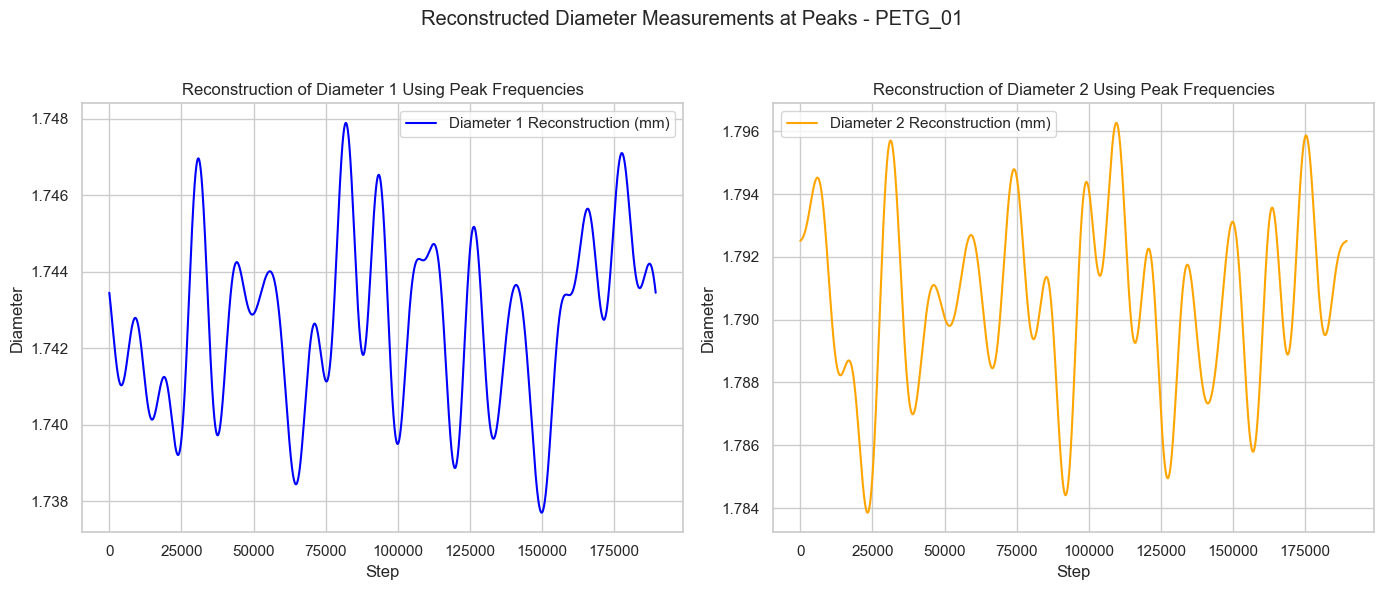

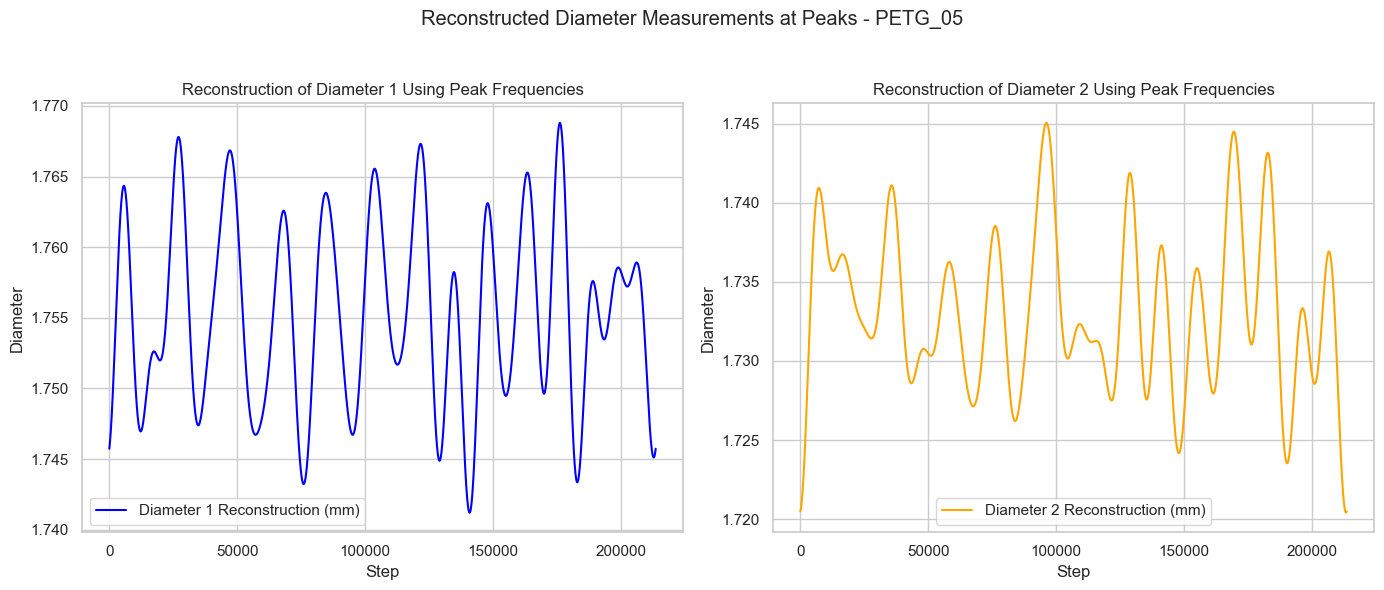

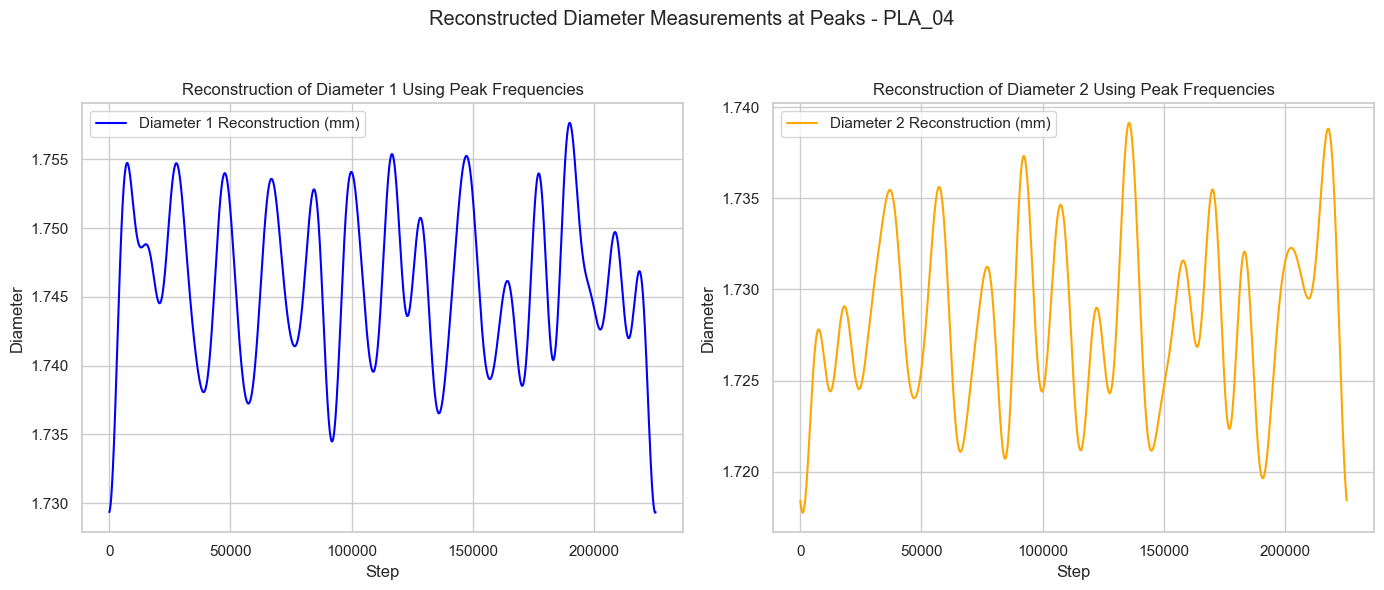

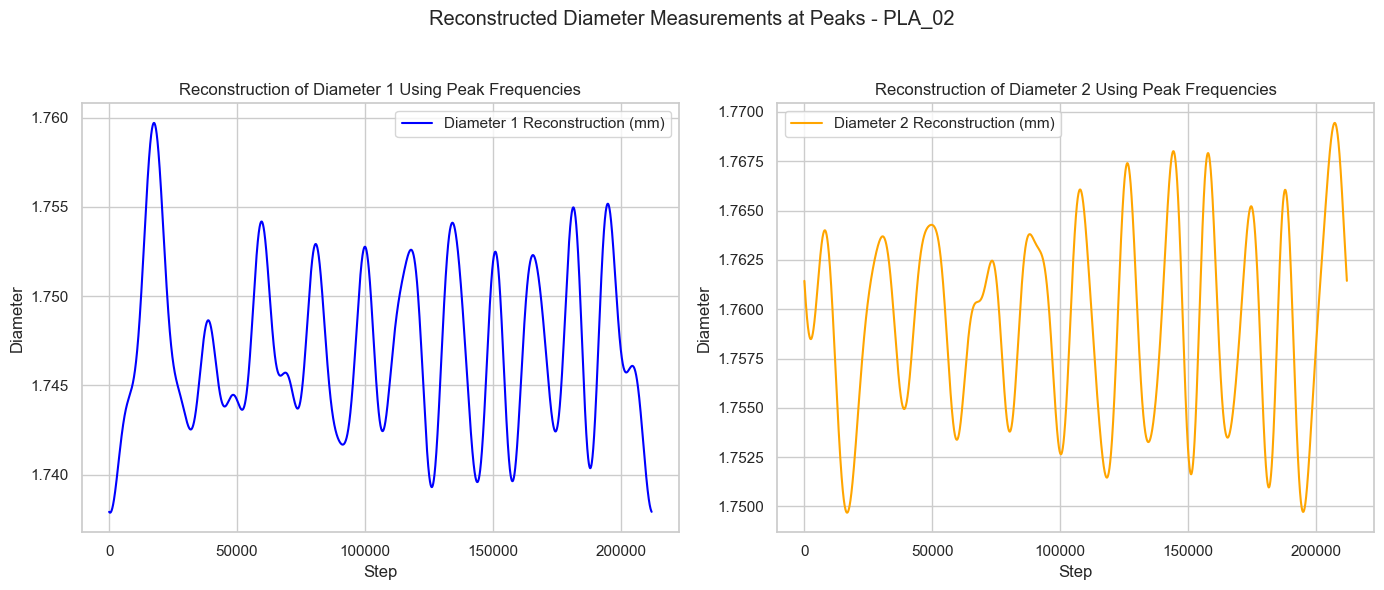

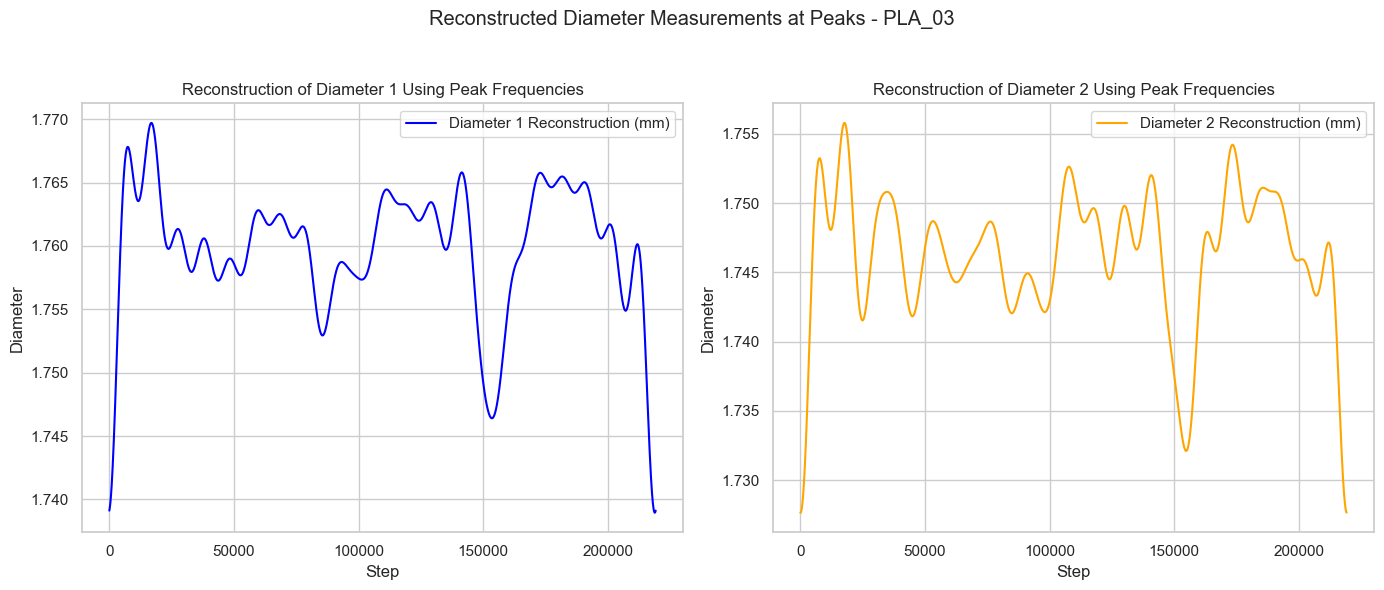

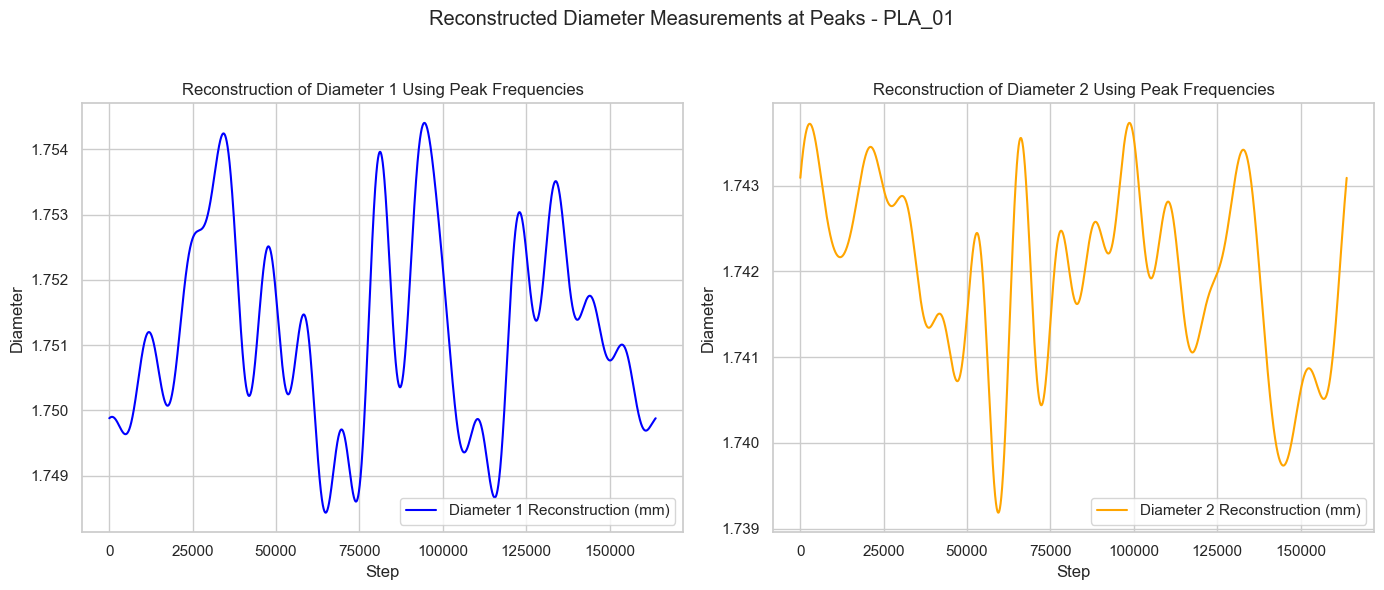

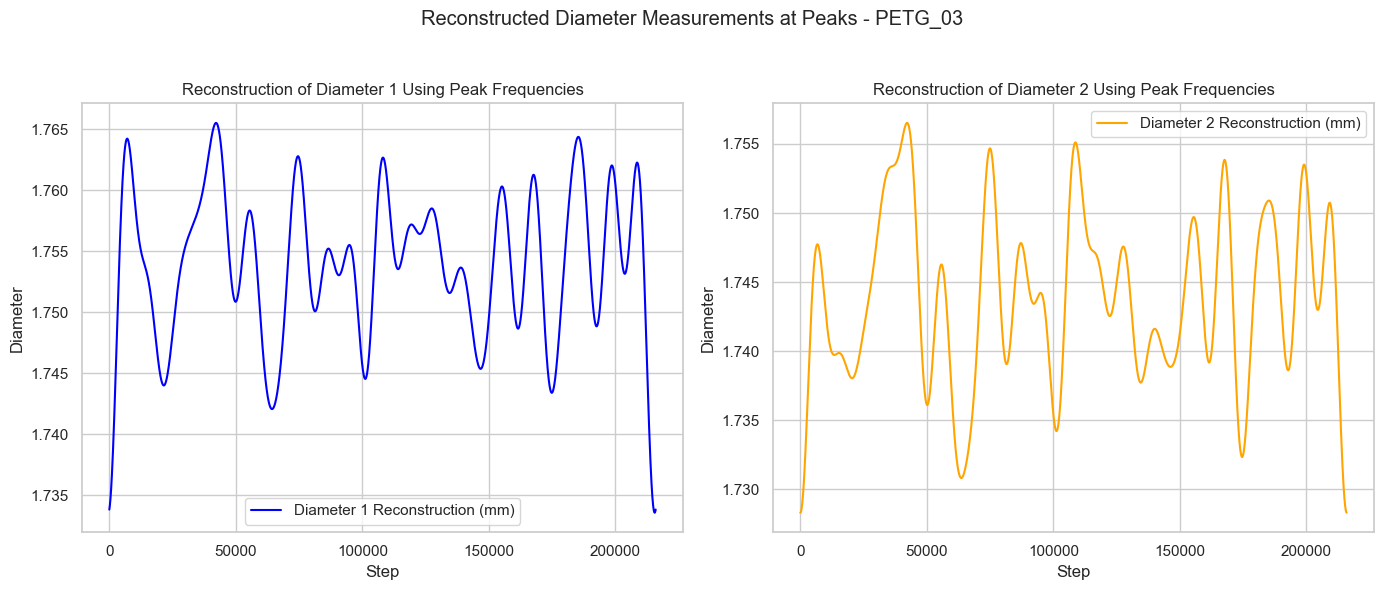

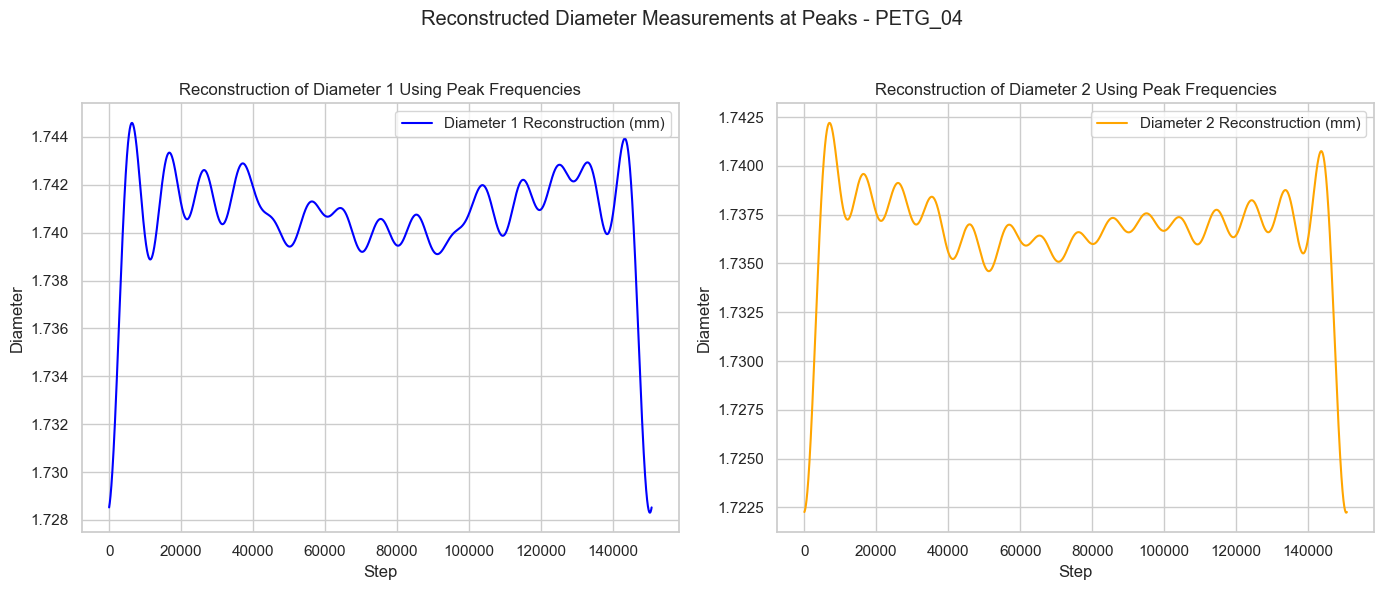

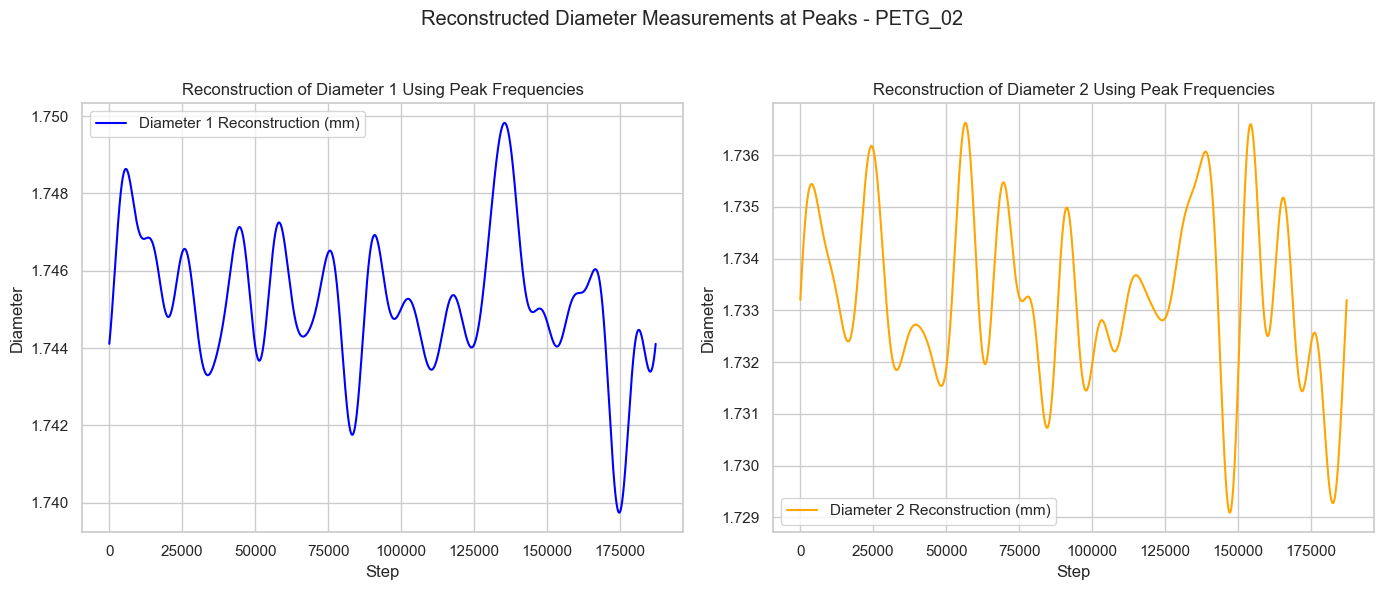

In [56]:
def plot_isolated_peak_reconstruction(df, title_suffix=''):
    if 'diameter_1' not in df.columns or 'diameter_2' not in df.columns:
        print("Necessary columns are missing in the DataFrame.")
        return

    # Perform FFT
    fft_diameter1 = np.fft.fft(df['diameter_1'].dropna())
    fft_diameter2 = np.fft.fft(df['diameter_2'].dropna())
    freq = np.fft.fftfreq(len(fft_diameter1), d=1)  # Assume uniform sampling

    # Find peaks in the frequency domain within the specified range
    range_indices = (freq > 1e-5) & (freq < 1e-4)
    isolated_indices = range_indices | (freq == 0)  # Also include the DC component
    fft_diameter1[~isolated_indices] = 0  # Zero out all frequencies not near the peak or DC
    fft_diameter2[~isolated_indices] = 0

    # Perform Inverse FFT with isolated peak frequencies
    ifft_diameter1 = np.fft.ifft(fft_diameter1)
    ifft_diameter2 = np.fft.ifft(fft_diameter2)

    # Plotting the reconstructed signals
    plot_reconstructed_signals(df.index, ifft_diameter1, ifft_diameter2, 'Reconstructed Diameter Measurements at Peaks' + title_suffix)

def plot_reconstructed_signals(pos_steps, ifft_signal_d1, ifft_signal_d2, title):
    plt.figure(figsize=(14, 6))

    plt.subplot(121)
    plt.plot(pos_steps, np.real(ifft_signal_d1), label='Diameter 1 Reconstruction (mm)', color='blue')
    plt.title('Reconstruction of Diameter 1 Using Peak Frequencies')
    plt.xlabel('Step')
    plt.ylabel('Diameter')
    plt.legend()
    plt.grid(True)

    plt.subplot(122)
    plt.plot(pos_steps, np.real(ifft_signal_d2), label='Diameter 2 Reconstruction (mm)', color='orange')
    plt.title('Reconstruction of Diameter 2 Using Peak Frequencies')
    plt.xlabel('Step')
    plt.ylabel('Diameter')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

if 'segment_switch' in globals() and segment_switch:
    for name, segments in dataframes.items():
        for segment_name, segment_df in segments.items():
            plot_isolated_peak_reconstruction(segment_df, title_suffix=f' - {name} {segment_name}')
else:
    for name, df in dataframes.items():
        plot_isolated_peak_reconstruction(df, title_suffix=f' - {name}')

# Frequency Analysis for Diameter Difference (Compared with Frequency Analysis of Diameter1/Diameter2 Measurements)

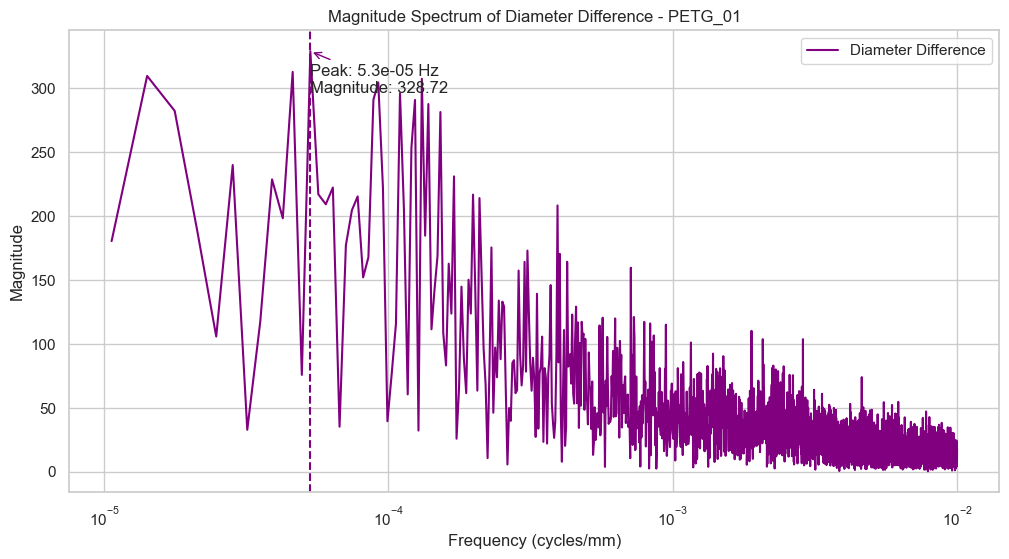

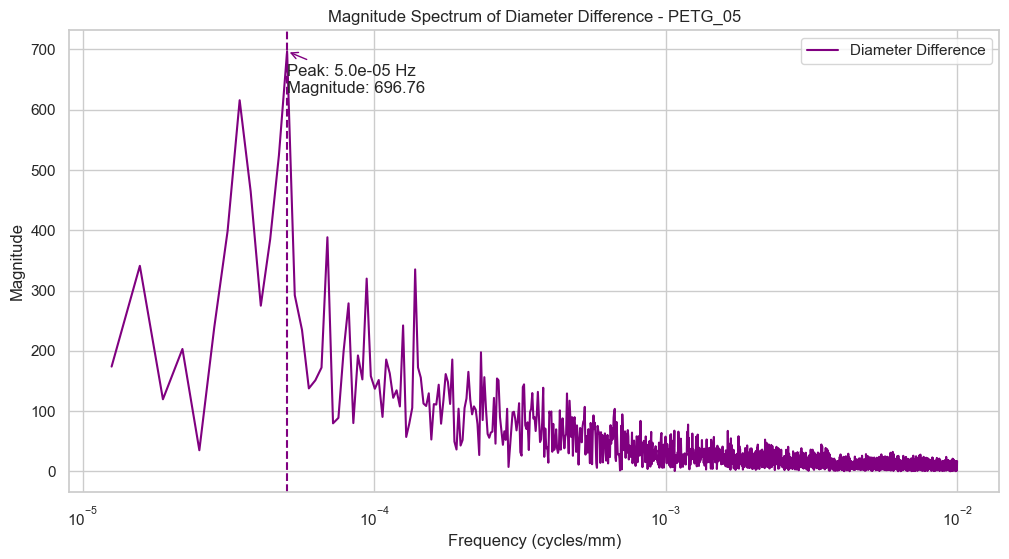

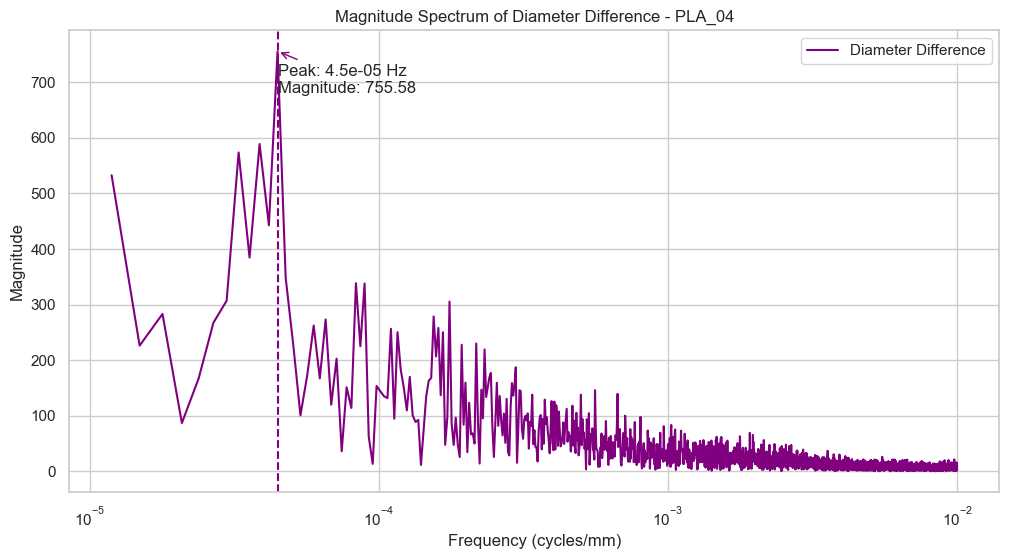

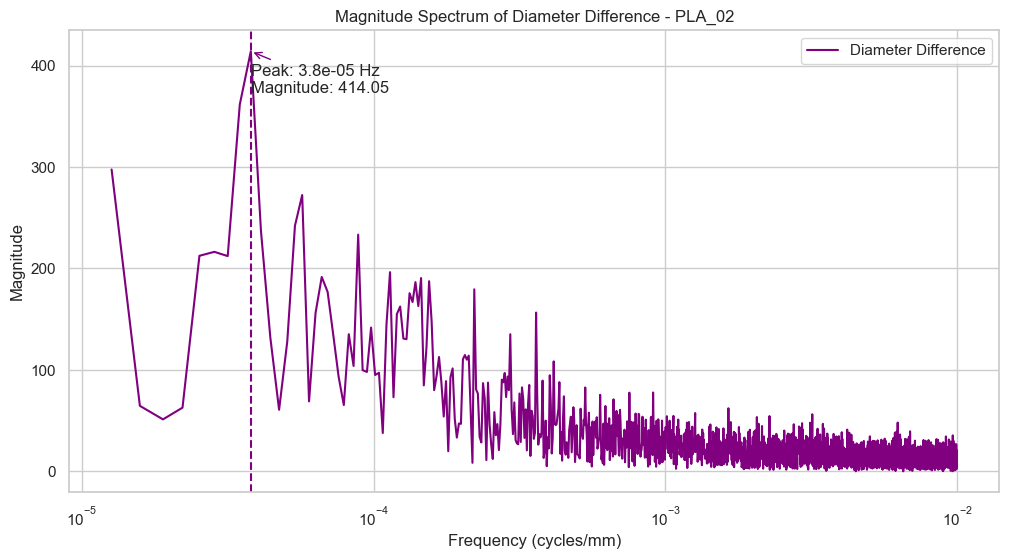

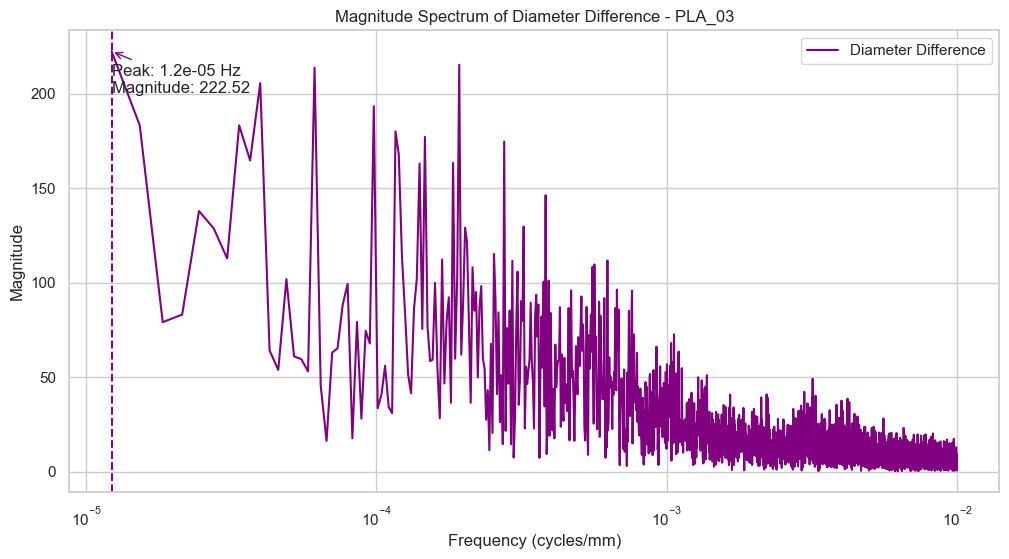

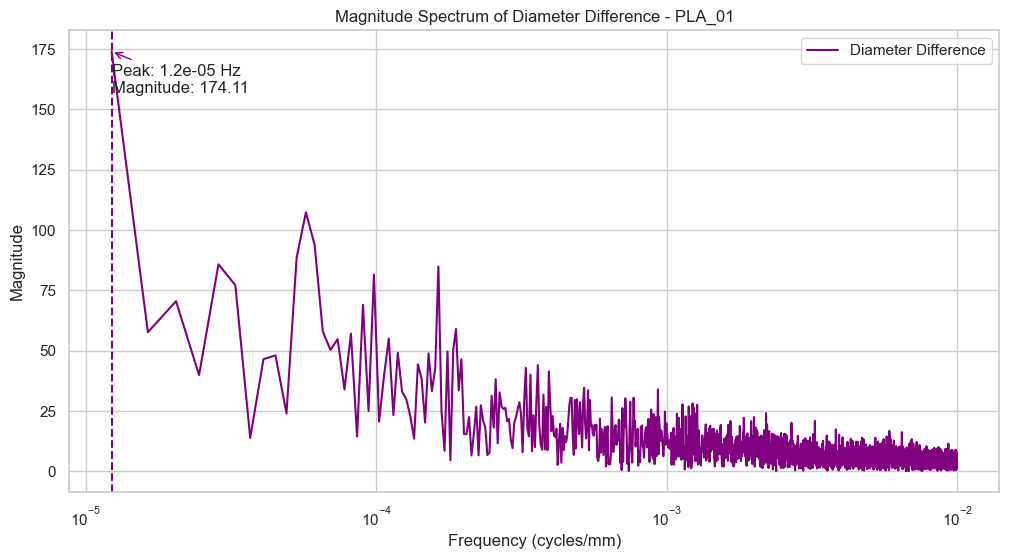

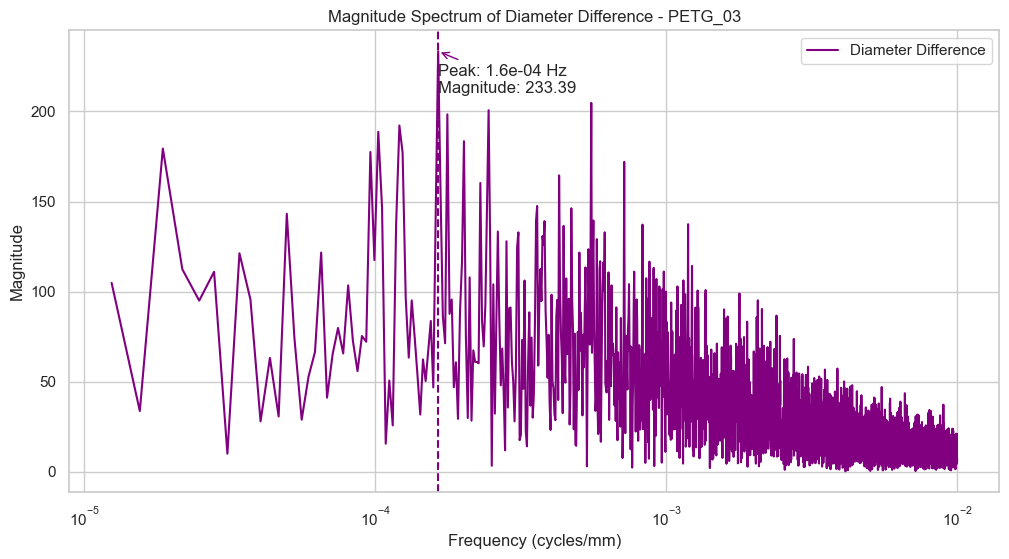

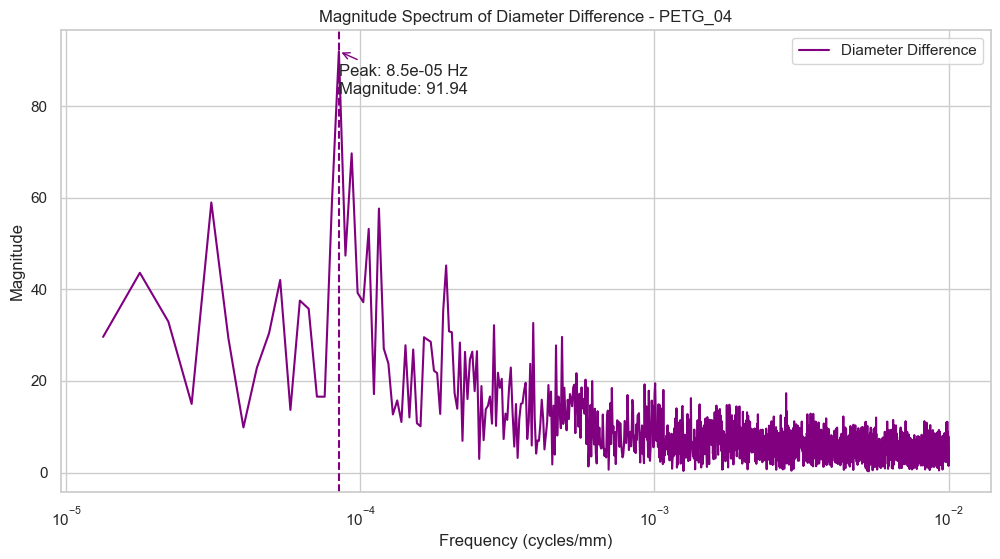

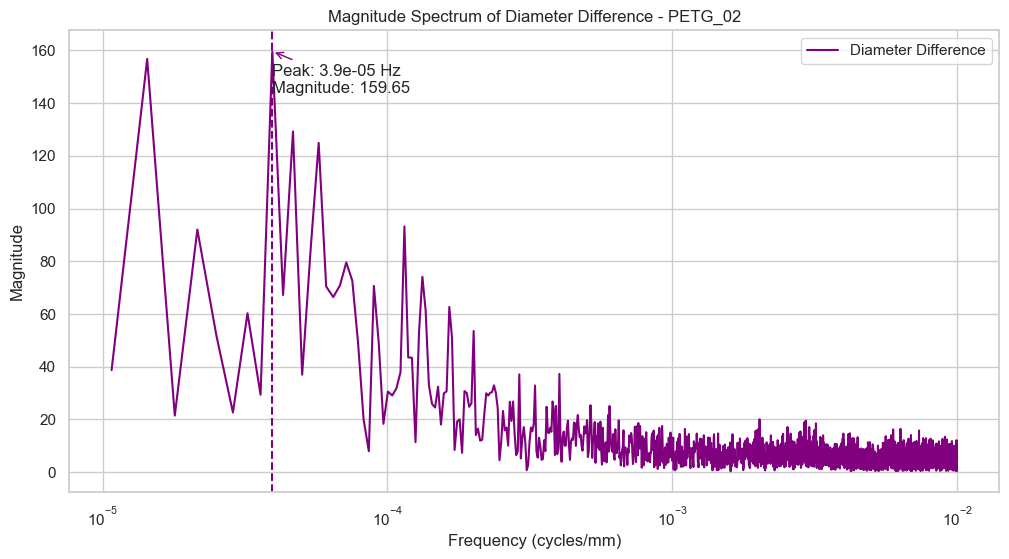

In [57]:
def analyze_frequency_response(df, title_suffix=''):
    if 'diameter_difference' not in df.columns:
        print("Necessary column 'diameter_difference' is missing in the DataFrame.")
        return
    
    # Perform Fourier Transform
    fft_diameter_difference = np.fft.fft(df['diameter_difference'].dropna())
    freq = np.fft.fftfreq(len(fft_diameter_difference), d=1.49)  # Adjust d if known differently
    positive_freq_indices = freq > 0
    freq = freq[positive_freq_indices]
    fft_diameter_difference = fft_diameter_difference[positive_freq_indices]
    
    # Filtering frequencies for relevant range
    relevant_freq_indices = (freq > 1e-5) & (freq <= 1e-2)
    freq_relevant = freq[relevant_freq_indices]
    magnitude_difference_relevant = np.abs(fft_diameter_difference[relevant_freq_indices])
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.semilogx(freq_relevant, magnitude_difference_relevant, label='Diameter Difference', color='purple')
    peaks_indices = np.where(magnitude_difference_relevant == np.max(magnitude_difference_relevant))[0]
    for peak_index in peaks_indices:
        peak_freq = freq_relevant[peak_index]
        plt.axvline(x=peak_freq, color='purple', linestyle='--')
        plt.annotate(f'Peak: {peak_freq:.1e} Hz\nMagnitude: {magnitude_difference_relevant[peak_index]:.2f}',
                     xy=(peak_freq, magnitude_difference_relevant[peak_index]), xytext=(peak_freq, magnitude_difference_relevant[peak_index]*0.9),
                     textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='purple'))
    plt.title('Magnitude Spectrum of Diameter Difference' + title_suffix)
    plt.xlabel('Frequency (cycles/mm)')
    plt.ylabel('Magnitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Example usage
for name, df in dataframes.items():
    analyze_frequency_response(df, title_suffix=f' - {name}')

In [58]:
comparison_results = pd.DataFrame(columns=['Name', 'Type', 'Peak Frequency', 'Peak Magnitude'])

def append_analysis_results(df, name, type_suffix):
    """ Appends peak frequency and magnitude of the Fourier transform to the comparison DataFrame. """
    fft_data = np.fft.fft(df.dropna())
    freq = np.fft.fftfreq(len(fft_data), d=1)  # Assuming d=1 for sample spacing
    positive_freq_indices = freq > 0
    freq = freq[positive_freq_indices]
    fft_data = fft_data[positive_freq_indices]
    
    magnitude = np.abs(fft_data)
    peak_index = np.argmax(magnitude)
    peak_freq = freq[peak_index]
    peak_magnitude = magnitude[peak_index]
    
    # Append results to the DataFrame
    comparison_results.loc[len(comparison_results)] = [name, type_suffix, peak_freq, peak_magnitude]

# Populate comparison DataFrame
for name, df in dataframes.items():
    if 'diameter_1' in df.columns and 'diameter_2' in df.columns:
        append_analysis_results(df['diameter_1'], name, 'Diameter 1')
        append_analysis_results(df['diameter_2'], name, 'Diameter 2')
        append_analysis_results(df['diameter_difference'], name, 'Diameter Difference')

# New column to indicate close frequency match
comparison_results['Close Match'] = False

# Define tolerance for frequency closeness
tolerance = 0.000005

# Update 'Close Match' column based on the tolerance condition
for name in comparison_results['Name'].unique():
    group_data = comparison_results[comparison_results['Name'] == name]
    dia_diff_freq = group_data[group_data['Type'] == 'Diameter Difference']['Peak Frequency'].values[0]
    dia1_freq = group_data[group_data['Type'] == 'Diameter 1']['Peak Frequency'].values[0]
    dia2_freq = group_data[group_data['Type'] == 'Diameter 2']['Peak Frequency'].values[0]

    # Check if the diameter difference peak frequency is within tolerance of either diameter peak frequency
    if abs(dia_diff_freq - dia1_freq) <= tolerance or abs(dia_diff_freq - dia2_freq) <= tolerance:
        # Mark the Diameter Difference row as a close match
        comparison_results.loc[(comparison_results['Name'] == name) & (comparison_results['Type'] == 'Diameter Difference'), 'Close Match'] = True

# Output the DataFrame with highlighted close matches
print(comparison_results)

       Name                 Type  Peak Frequency  Peak Magnitude  Close Match
0   PETG_01           Diameter 1        0.000005      327.528919        False
1   PETG_01           Diameter 2        0.000005      439.533935        False
2   PETG_01  Diameter Difference        0.000079      328.724313        False
3   PETG_05           Diameter 1        0.000052     1007.123340        False
4   PETG_05           Diameter 2        0.000005     1118.664301        False
5   PETG_05  Diameter Difference        0.000005      803.435689         True
6    PLA_04           Diameter 1        0.000004     1011.954442        False
7    PLA_04           Diameter 2        0.000004     1028.916844        False
8    PLA_04  Diameter Difference        0.000004      876.892796         True
9    PLA_02           Diameter 1        0.000061      589.024094        False
10   PLA_02           Diameter 2        0.000005      794.424426        False
11   PLA_02  Diameter Difference        0.000057      414.047234

In [59]:
def remove_outliers(df, column_name):
    if column_name in df.columns:
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df

def apply_rolling_average_and_downsample(df, downsample_factor, rolling_avg_resolution):
    # Create a copy to avoid modifying the original dataframe unintentionally
    df_copy = df.copy()

    # Apply rolling average conditionally on column existence
    if 'length' in df_copy.columns:
        df_copy['length_ra'] = df_copy['length'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_1' in df_copy.columns:
        df_copy['diameter_1_ra'] = df_copy['diameter_1'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_2' in df_copy.columns:
        df_copy['diameter_2_ra'] = df_copy['diameter_2'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_1_ra' in df_copy.columns and 'diameter_2_ra' in df_copy.columns:
        df_copy['diameter_avg_ra'] = df_copy[['diameter_1_ra', 'diameter_2_ra']].mean(axis=1)
    elif 'diameter_avg' in df_copy.columns:
        df_copy['diameter_avg_ra'] = df_copy['diameter_avg'].rolling(window=rolling_avg_resolution, min_periods=1).mean()

    # Downsample by selecting every 'downsample_factor' row
    downsampled_df = df_copy.iloc[::downsample_factor].copy()  # Ensure to copy the downsized data to reset the index and avoid future warnings
    return downsampled_df

Processing PETG_01
count    189328.000000
mean          1.766620
std           0.013860
min           1.709786
25%           1.757262
50%           1.766930
75%           1.776273
max           1.821860
Name: diameter_avg, dtype: float64


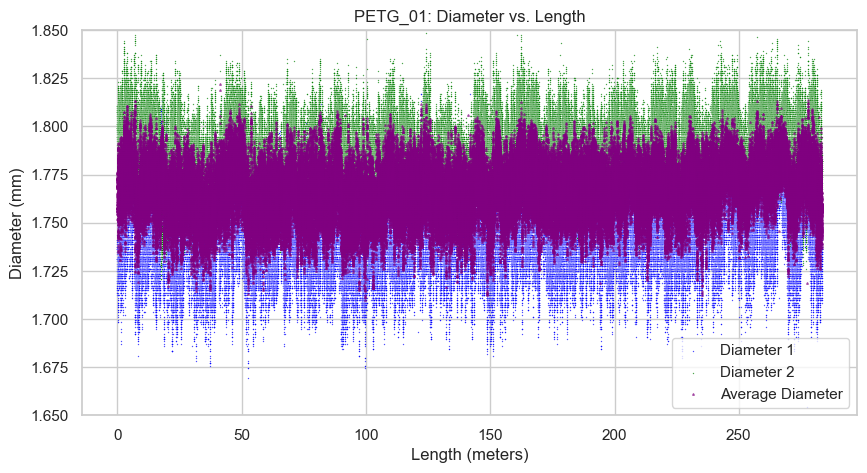

Processing PETG_05
count    213405.000000
mean          1.744950
std           0.009042
min           1.708193
25%           1.738582
50%           1.744415
75%           1.751275
max           1.774275
Name: diameter_avg, dtype: float64


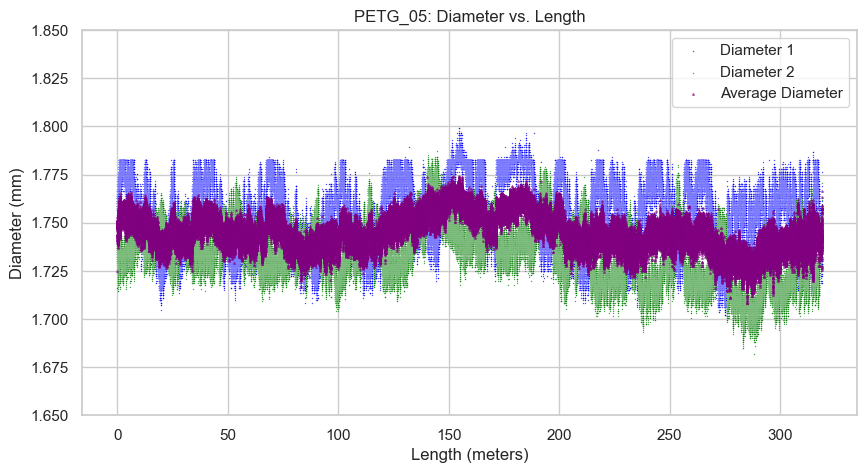

Processing PLA_04
count    225428.000000
mean          1.737767
std           0.005766
min           1.702932
25%           1.734051
50%           1.738010
75%           1.741694
max           1.791658
Name: diameter_avg, dtype: float64


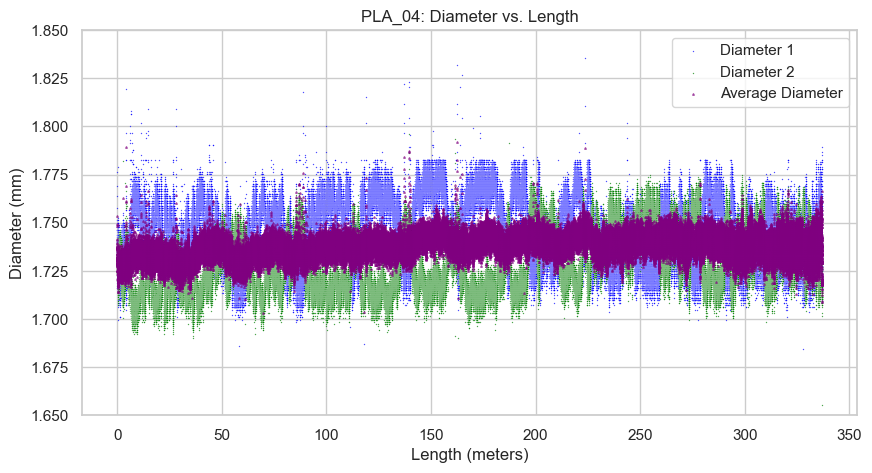

Processing PLA_02
count    212075.000000
mean          1.753198
std           0.006791
min           1.707000
25%           1.749206
50%           1.753498
75%           1.757442
max           1.797209
Name: diameter_avg, dtype: float64


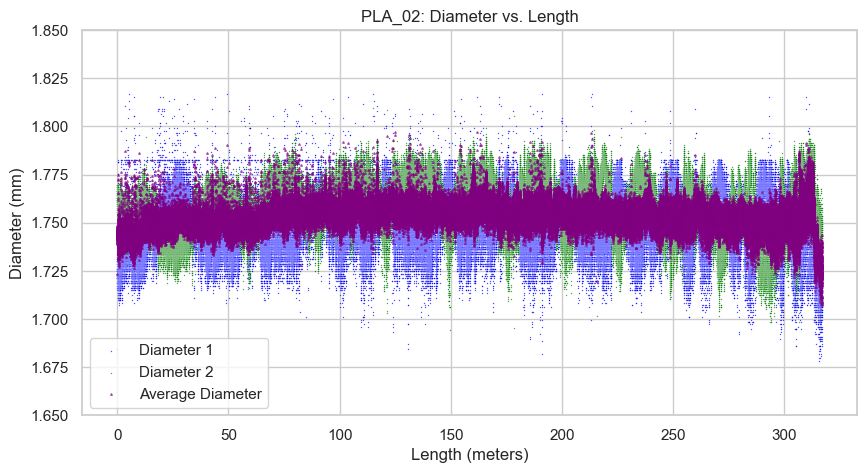

Processing PLA_03
count    218947.000000
mean          1.753964
std           0.019829
min           1.655738
25%           1.741730
50%           1.755669
75%           1.768283
max           1.819174
Name: diameter_avg, dtype: float64


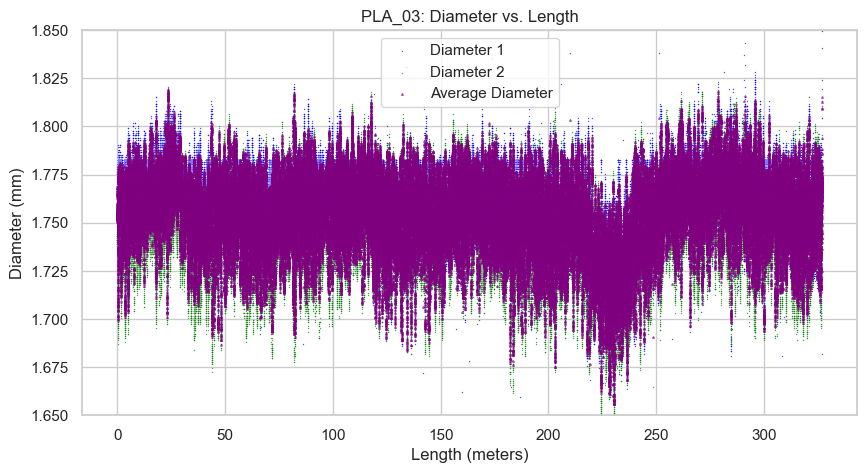

Processing PLA_01
count    163705.000000
mean          1.746584
std           0.005372
min           1.721864
25%           1.742953
50%           1.746608
75%           1.750183
max           1.772509
Name: diameter_avg, dtype: float64


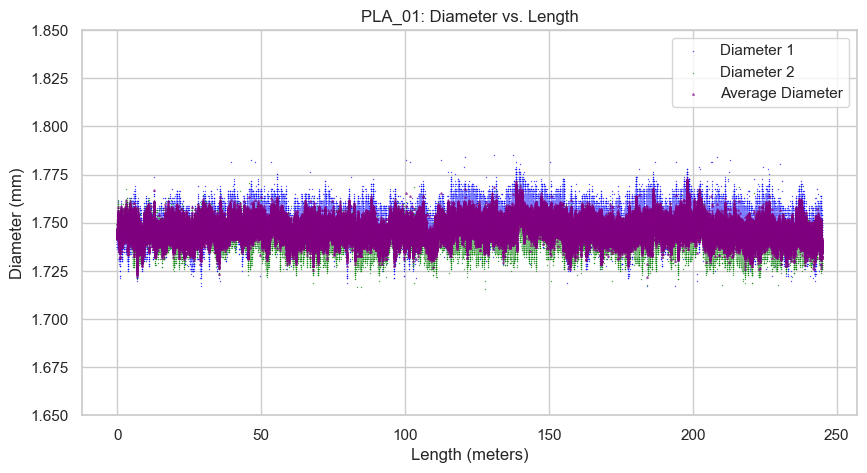

Processing PETG_03
count    215790.000000
mean          1.749573
std           0.019330
min           1.673020
25%           1.737243
50%           1.750834
75%           1.763427
max           1.823735
Name: diameter_avg, dtype: float64


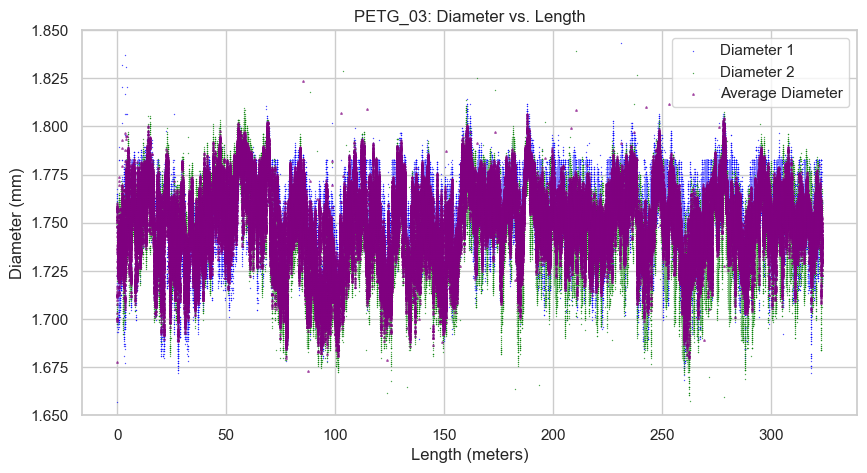

Processing PETG_04
count    149805.000000
mean          1.739366
std           0.007651
min           1.709149
25%           1.734522
50%           1.738727
75%           1.743358
max           1.773465
Name: diameter_avg, dtype: float64


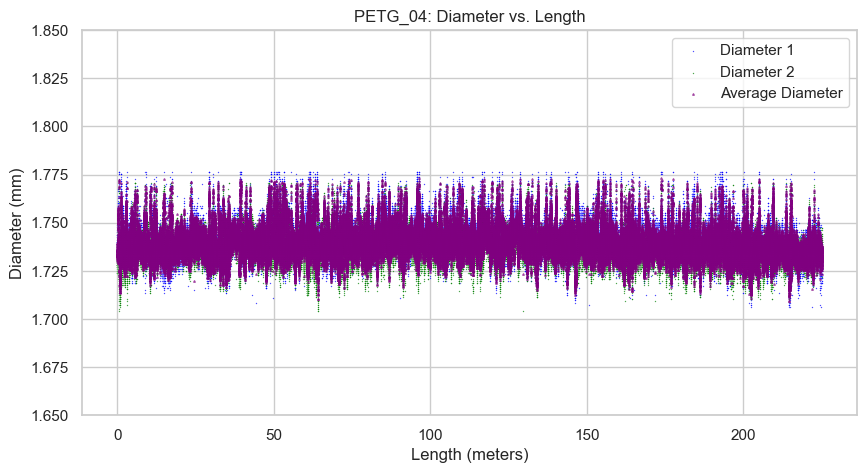

Processing PETG_02
count    187101.000000
mean          1.739234
std           0.005235
min           1.713230
25%           1.735737
50%           1.739334
75%           1.742729
max           1.764910
Name: diameter_avg, dtype: float64


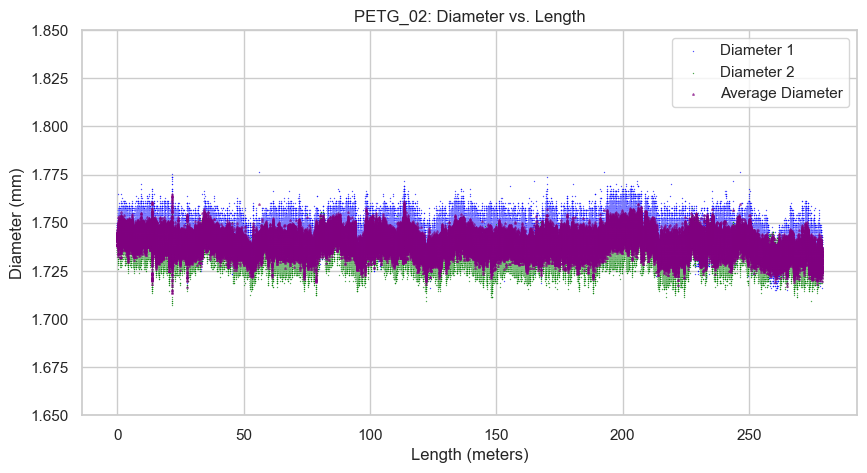

In [64]:
def plot_diameters(df, title, use_rolling_average):    
    plt.figure(figsize=(10, 5))
    # Convert x values from mm to meters
    x = df['length_ra'] / 1000 if use_rolling_average else df['length'] / 1000
    y1 = df['diameter_1_ra'] if use_rolling_average else df['diameter_1']
    y2 = df['diameter_2_ra'] if use_rolling_average else df['diameter_2']
    y_avg = df['diameter_avg_ra'] if use_rolling_average else df['diameter_avg']
    sns.scatterplot(x=x, y=y1, alpha=0.7, label='Diameter 1', color='blue', s=1)
    sns.scatterplot(x=x, y=y2, alpha=0.7, label='Diameter 2', color='green', s=1)
    plt.scatter(x, y_avg, alpha=0.7, label='Average Diameter', color='purple', s=1, marker='^')
    plt.title(title)
    plt.xlabel('Length (meters)')
    plt.ylabel('Diameter (mm)')
    plt.ylim(1.65, 1.85)
    plt.legend()
    plt.grid(True)
    warnings.simplefilter("ignore", category=UserWarning)
    plt.show()

# Loop to process dataframes
for name, item in dataframes.items():
    if segment_switch and isinstance(item, dict):
        for segment_name, segment_df in item.items():
            print(f"Processing {name} - {segment_name}")
            segment_df = remove_outliers(segment_df, 'diameter_1')
            segment_df = remove_outliers(segment_df, 'diameter_2')
            segment_df['diameter_avg'] = segment_df[['diameter_1', 'diameter_2']].mean(axis=1)
            if rolling_average_switch:
                segment_df = apply_rolling_average_and_downsample(segment_df, down_sample_value, rolling_avg_resolution)
            dataframes[name][segment_name] = segment_df
            print(segment_df['diameter_avg'].describe())
            plot_diameters(segment_df, f"{name} - {segment_name}: Diameter vs. Length", rolling_average_switch)
    elif isinstance(item, pd.DataFrame):
        print(f"Processing {name}")
        item = remove_outliers(item, 'diameter_1')
        item = remove_outliers(item, 'diameter_2')
        item['diameter_avg'] = item[['diameter_1', 'diameter_2']].mean(axis=1)
        if rolling_average_switch:
            item = apply_rolling_average_and_downsample(item, down_sample_value, rolling_avg_resolution)
        dataframes[name] = item
        print(item['diameter_avg'].describe())
        plot_diameters(item, f"{name}: Diameter vs. Length", rolling_average_switch)
    else:
        print(f"Unsupported data structure in dataframes[{name}]")

In [66]:
processed_dataframes = {}
for name, item in dataframes.items():
    if segment_switch and isinstance(item, dict):  # Check if dataframes are segmented
        for segment_name, df in item.items():
            if rolling_average_switch:
                df = segment_df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)
            
            std = df['diameter_avg'].std()
            n = df['diameter_avg'].count()
            df['segment'] = segment_name  # Adding segment identifier
            df['group'] = name  # Group by filament type
            processed_dataframes[f"{name}_{segment_name}"] = df
    elif isinstance(item, pd.DataFrame):  # Handle non-segmented dataframes
        if rolling_average_switch:
            item = segment_df = apply_rolling_average_and_downsample(item, down_sample_value, rolling_avg_resolution)

        std = item['diameter_avg'].std()
        n = item['diameter_avg'].count()
        item['group'] = name  # Group by filament type
        processed_dataframes[name] = item
    else:
        print(f"Unsupported data structure in dataframes[{name}]")

# Concatenate all the data into a single DataFrame
combined_df = pd.concat(processed_dataframes.values(), ignore_index=True)

if segment_switch:
    warnings.simplefilter("ignore", category=FutureWarning)
    
    # Ensure combined_df has the necessary columns and data
    combined_df['segment'] = pd.Categorical(combined_df['segment'], 
                                            categories=['first', 'second', 'third', 'fourth', 'fifth', 'sixth'], 
                                            ordered=True)
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=combined_df, x='segment', y='diameter_avg', hue='group', marker='o')
    plt.title('Interaction Plot for Filament Type and Section Within')
    plt.xlabel('Section')
    plt.ylabel('Average Diameter')
    plt.xticks(rotation=45)
    plt.legend(title='Group')
    plt.tight_layout()
    plt.show()

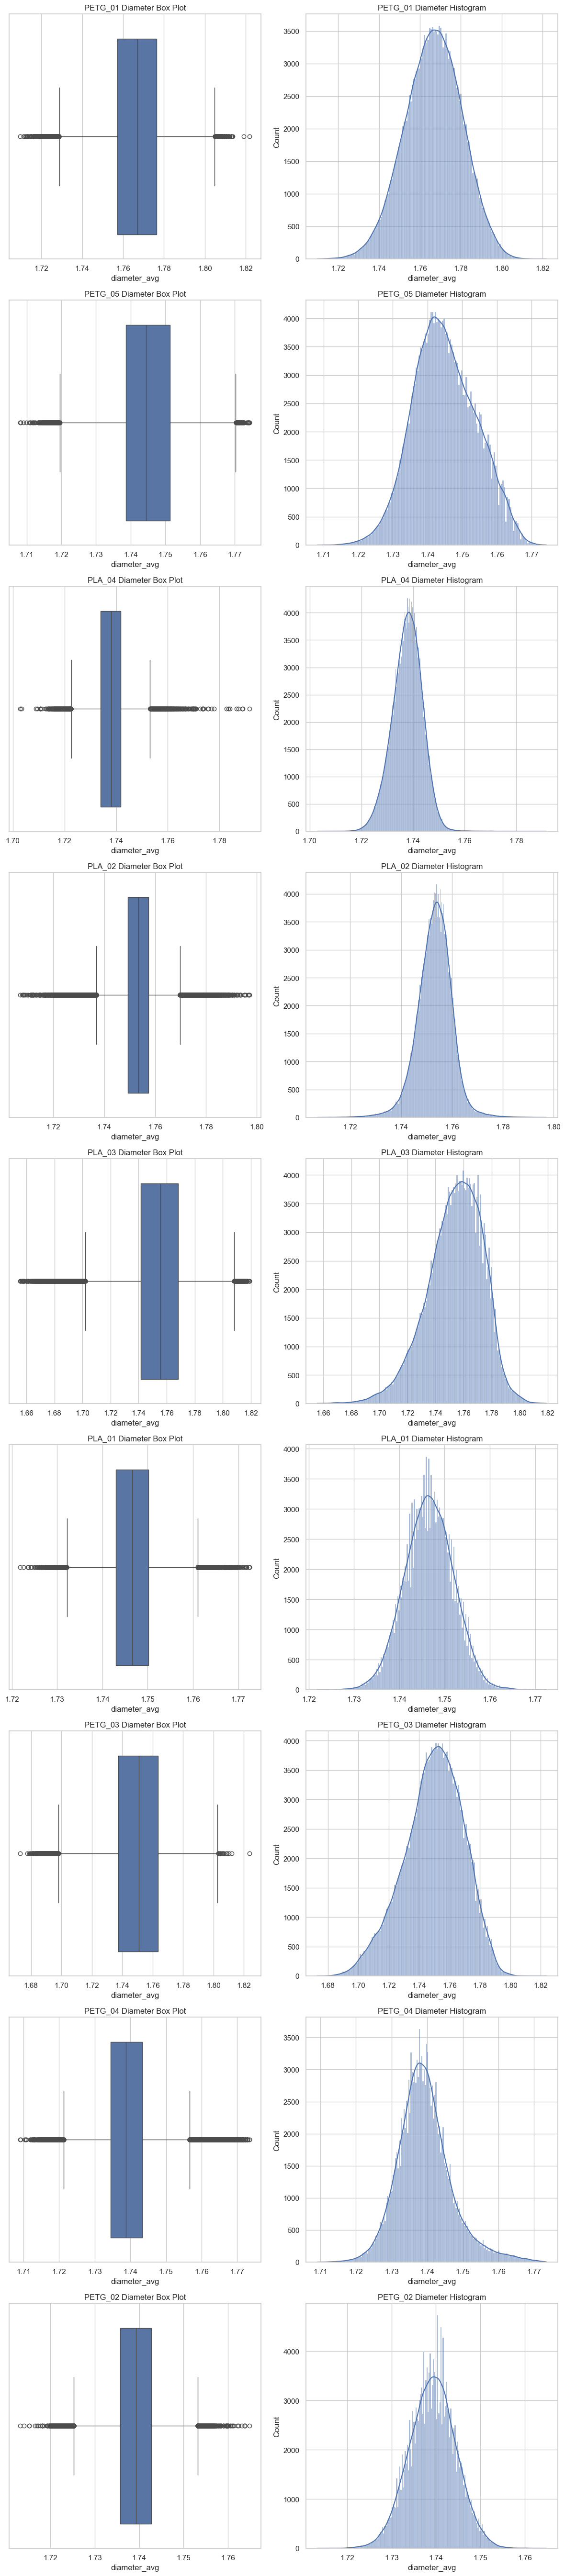

In [67]:
sns.set(style="whitegrid")

# Function to create plots for a given DataFrame
def create_plots(df, axs, row_index, name):
    if rolling_average_switch:
        # Use the rolling average DataFrame if the switch is on
        df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)

    sns.boxplot(x=df['diameter_avg'], ax=axs[row_index, 0]).set_title(f'{name} Diameter Box Plot')

    sns.histplot(df['diameter_avg'], kde=True, ax=axs[row_index, 1]).set_title(f'{name} Diameter Histogram')

num_plots = sum(len(v) for v in dataframes.values() if isinstance(v, dict)) if segment_switch else len(dataframes)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    fig, axs = plt.subplots(num_plots, 2, figsize=(12, 6 * num_plots))
    row_index = 0
    for name, item in dataframes.items():
        if segment_switch and isinstance(item, dict):
            for segment_name, df_segment in item.items():
                plot_title = f"{name} - {segment_name}"
                create_plots(df_segment, axs, row_index, plot_title)
                row_index += 1
        elif isinstance(item, pd.DataFrame):
            plot_title = f"{name}"
            create_plots(item, axs, row_index, plot_title)
            row_index += 1
        else:
            print(f"Unsupported data structure in dataframes[{name}]")
    plt.tight_layout()
    plt.show()


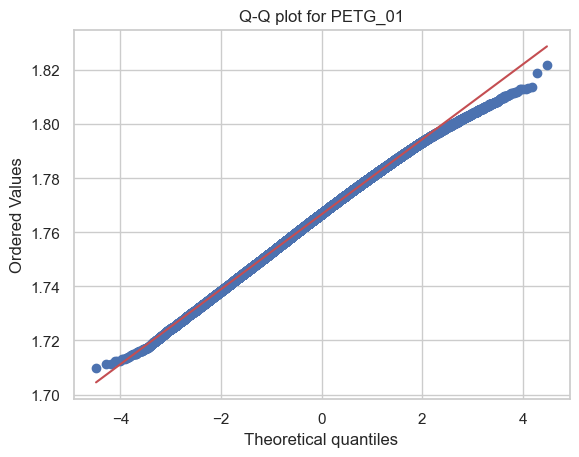

PETG_01 - Skewness: -0.12222686476670368, Kurtosis: -0.13033390990024074


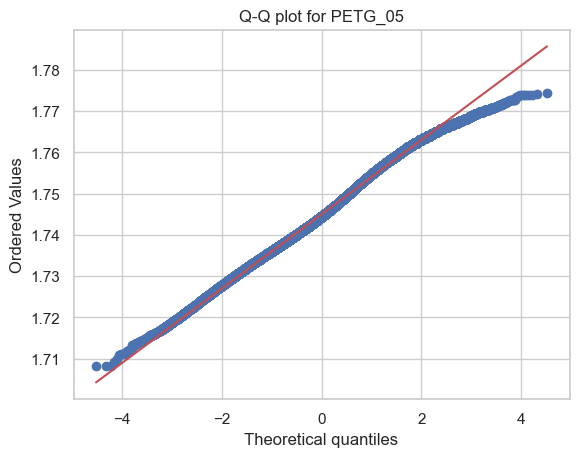

PETG_05 - Skewness: 0.09012148030147654, Kurtosis: -0.2873635581596181


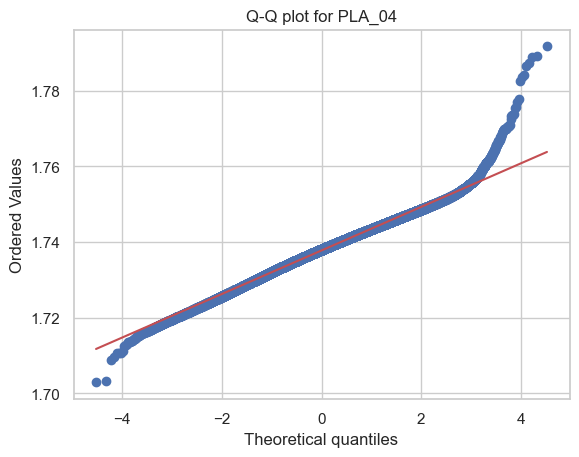

PLA_04 - Skewness: -0.13032390706993863, Kurtosis: 0.5047426066006131


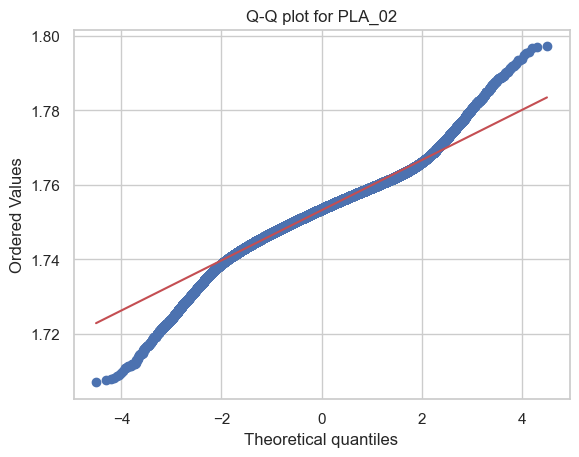

PLA_02 - Skewness: -0.24086324456089916, Kurtosis: 2.15789827218145


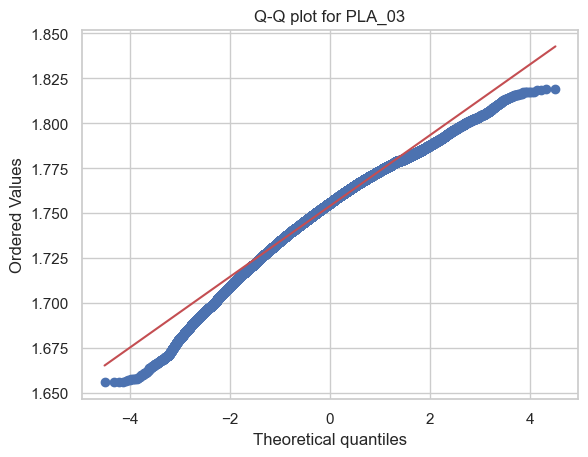

PLA_03 - Skewness: -0.524510415656508, Kurtosis: 0.45089273474593217


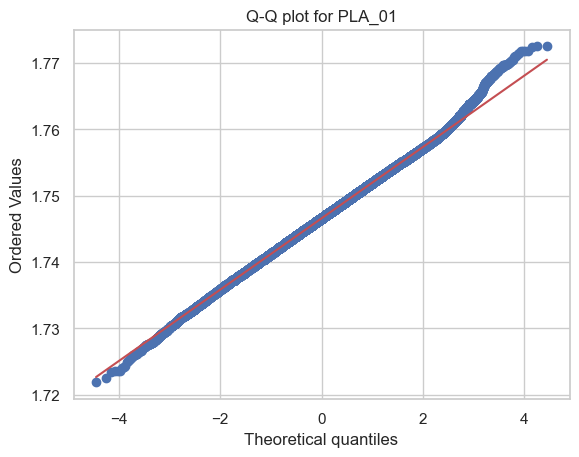

PLA_01 - Skewness: 0.014383229777193201, Kurtosis: 0.17025814281373997


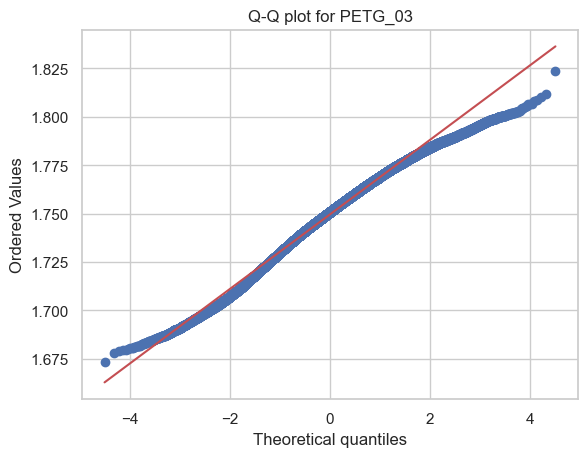

PETG_03 - Skewness: -0.3354685010473456, Kurtosis: -0.15124674069762145


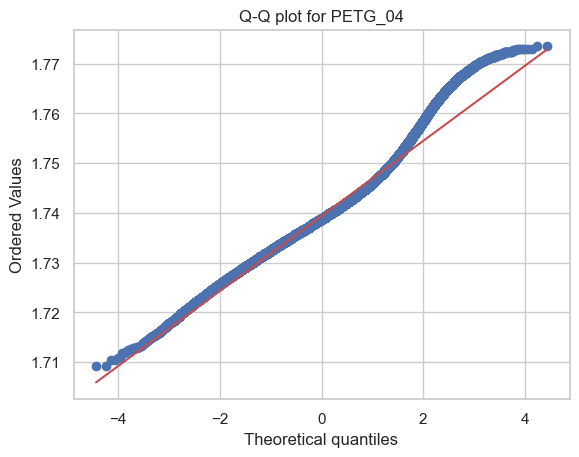

PETG_04 - Skewness: 0.6604079425969509, Kurtosis: 1.371774513470645


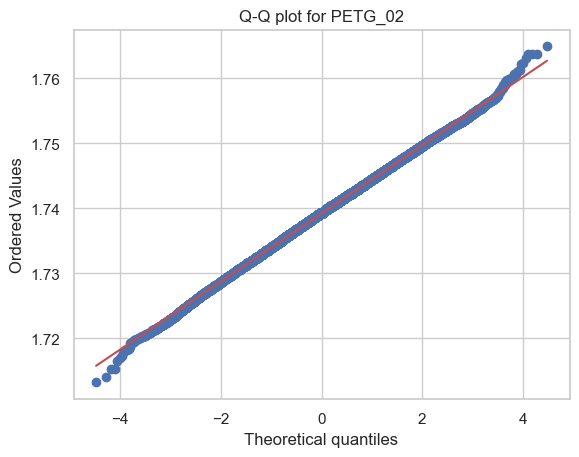

PETG_02 - Skewness: -0.0487154915998606, Kurtosis: 0.029546948027108666


In [68]:
def create_plots(df, axs, row_index, name):
    if rolling_average_switch:
        # Use the rolling average DataFrame if the switch is on
        df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)

    sns.boxplot(x=df['diameter_avg'], ax=axs[row_index, 0]).set_title(f'{name} Diameter Box Plot')
    sns.histplot(df['diameter_avg'], kde=True, ax=axs[row_index, 1]).set_title(f'{name} Diameter Histogram')
    
    # Add a Q-Q plot
    fig, ax = plt.subplots()
    stats.probplot(df['diameter_avg'].dropna(), dist="norm", plot=ax)
    ax.set_title(f'Q-Q plot for {name}')
    plt.show()

    # Calculate and display skewness and kurtosis
    skewness = df['diameter_avg'].skew()
    kurtosis = df['diameter_avg'].kurtosis()
    print(f"{name} - Skewness: {skewness}, Kurtosis: {kurtosis}")

    # Optional: You could still display Shapiro-Wilk results but take them with a grain of salt for large datasets
    if len(df['diameter_avg'].dropna()) < 5000:  # Limit to reasonable size for Shapiro-Wilk
        stat, p = shapiro(df['diameter_avg'].dropna())
        print(f"Normality test for {name}: Statistics={stat:.3f}, p-value={p:.3g}")
        if p > 0.05:
            print(f"The diameter data for {name} looks normally distributed (fail to reject H0)")
        else:
            print(f"The diameter data for {name} does not look normally distributed (reject H0)")

row_index = 0
for group_name, segments in dataframes.items():
    if isinstance(segments, dict):  # Checks if the value is a nested dictionary
        for segment_name, df in segments.items():
            plot_name = f"{group_name} - {segment_name}"  # Combines group and segment name for labeling
            create_plots(df, axs, row_index, plot_name)
            row_index += 1
    elif isinstance(segments, pd.DataFrame):  # Direct DataFrame
        create_plots(segments, axs, row_index, group_name)
        row_index += 1
    else:
        print(f"Unsupported data structure in dataframes[{group_name}]")

# Kruskal-Wallis Tests

## Evaluating difference in medians across groups against baseline, within sections of groups against each other, andwithin sections of groups against baseline

### Baseline = 1.75 mm
### Practical significance is set at a 0.01 mm difference, but can be changed

In [69]:
def epsilon_squared(H, n_total):
    """ Calculate epsilon squared for effect size. """
    return H * (n_total - 1) / (n_total ** 2 - 1)

def run_pairwise_comparisons(dataframes, segment_switch, practical_threshold=0.01):
    segments = {}  # Will hold the data for each segment or group for comparison
    
    # Collect data for Kruskal-Wallis test
    if segment_switch:
        # Handle segmented data
        for group_name, segments_dict in dataframes.items():
            for segment_name, df in segments_dict.items():
                key = f"{group_name}_{segment_name}"
                segments[key] = df['diameter_avg'].dropna().values
    else:
        # Handle whole group data
        for group_name, df in dataframes.items():
            segments[group_name] = df['diameter_avg'].dropna().values
    
    # Perform Kruskal-Wallis test across all segments/groups
    datasets = list(segments.values())
    labels = list(segments.keys())
    if len(datasets) > 1:
        stat, p = stats.kruskal(*datasets)
        n_total = sum(len(data) for data in datasets)
        eps_sq = epsilon_squared(stat, n_total)
        print(f"Kruskal-Wallis Test across {'segments' if segment_switch else 'groups'}:")
        print(f"Statistic: {stat}, p-value: {p:.3f}, epsilon squared: {eps_sq:.3f}\n")
        
        # Perform pairwise comparisons
        comparisons = []
        p_values = []
        actual_differences = []
        medians = {label: np.median(data) for label, data in segments.items()}
        for (data1, label1), (data2, label2) in itertools.combinations(zip(datasets, labels), 2):
            stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            comparisons.append((label1, label2))
            p_values.append(p)
            median_diff = abs(medians[label1] - medians[label2])
            actual_differences.append(median_diff)
        
        reject, p_adjusted, _, _ = multipletests(p_values, method='bonferroni')
        print("Pairwise Comparisons:")
        for (label1, label2), diff, p, p_adj, rej in zip(comparisons, actual_differences, p_values, p_adjusted, reject):
            print(f"{label1} vs {label2}:")
            print(f"  Median Difference: {diff:.4f}")
            if diff >= practical_threshold:
                print("  The difference is practically significant.")
            else:
                print("  The difference is not practically significant.")
        print("\n")
    else:
        print(f"Not enough data to perform Kruskal-Wallis test across {'segments' if segment_switch else 'groups'}.\n")

run_pairwise_comparisons(dataframes, segment_switch, practical_threshold=0.01)

Kruskal-Wallis Test across groups:
Statistic: 691378.6290136166, p-value: 0.000, epsilon squared: 0.389

Pairwise Comparisons:
PETG_01 vs PETG_05:
  Median Difference: 0.0225
  The difference is practically significant.
PETG_01 vs PLA_04:
  Median Difference: 0.0289
  The difference is practically significant.
PETG_01 vs PLA_02:
  Median Difference: 0.0134
  The difference is practically significant.
PETG_01 vs PLA_03:
  Median Difference: 0.0113
  The difference is practically significant.
PETG_01 vs PLA_01:
  Median Difference: 0.0203
  The difference is practically significant.
PETG_01 vs PETG_03:
  Median Difference: 0.0161
  The difference is practically significant.
PETG_01 vs PETG_04:
  Median Difference: 0.0282
  The difference is practically significant.
PETG_01 vs PETG_02:
  Median Difference: 0.0276
  The difference is practically significant.
PETG_05 vs PLA_04:
  Median Difference: 0.0064
  The difference is not practically significant.
PETG_05 vs PLA_02:
  Median Differenc

In [70]:
def run_wilcoxon_tests(dataframes, segment_switch, hypothesized_median=1.75):
    """Run Wilcoxon signed-rank tests against a hypothesized median for each group or segment."""
    results = {}  # This will store the test results

    # Collect data and perform the Wilcoxon signed-rank test
    if segment_switch:
        # Handle segmented data
        for group_name, segments_dict in dataframes.items():
            for segment_name, df in segments_dict.items():
                key = f"{group_name}_{segment_name}"
                if 'diameter_avg' in df.columns:
                    data = df['diameter_avg'].dropna().values
                    if len(data) > 0:
                        stat, p = stats.wilcoxon(data - hypothesized_median)
                        median_diff = np.median(data) - hypothesized_median
                        results[key] = (stat, p, median_diff)
    else:
        # Handle whole group data
        for group_name, df in dataframes.items():
            if 'diameter_avg' in df.columns:
                data = df['diameter_avg'].dropna().values
                if len(data) > 0:
                    stat, p = stats.wilcoxon(data - hypothesized_median)
                    median_diff = np.median(data) - hypothesized_median
                    results[group_name] = (stat, p, median_diff)

    print("Wilcoxon Signed-Rank Test Results Against Hypothesized Median:")
    for label, (stat, p, diff) in results.items():
        print(f"{label}:")
        print(f"  Test Statistic: {stat}, p-value: {p:.5f}")
        print(f"  Median Difference from Hypothesized Median: {diff:.4f}")
        if abs(diff) >= 0.01:  # Check against a practical significance level, if needed
            print("  The difference is considered practically significant.")
        else:
            print("  The difference is not considered practically significant.")
        print("\n")

run_wilcoxon_tests(dataframes, segment_switch, hypothesized_median=1.75)

Wilcoxon Signed-Rank Test Results Against Hypothesized Median:
PETG_01:
  Test Statistic: 852789876.0, p-value: 0.00000
  Median Difference from Hypothesized Median: 0.0169
  The difference is considered practically significant.


PETG_05:
  Test Statistic: 4961676511.0, p-value: 0.00000
  Median Difference from Hypothesized Median: -0.0056
  The difference is not considered practically significant.


PLA_04:
  Test Statistic: 38630005.0, p-value: 0.00000
  Median Difference from Hypothesized Median: -0.0120
  The difference is considered practically significant.


PLA_02:
  Test Statistic: 5217596233.0, p-value: 0.00000
  Median Difference from Hypothesized Median: 0.0035
  The difference is not considered practically significant.


PLA_03:
  Test Statistic: 8782708678.0, p-value: 0.00000
  Median Difference from Hypothesized Median: 0.0057
  The difference is not considered practically significant.


PLA_01:
  Test Statistic: 2449328210.0, p-value: 0.00000
  Median Difference from Hy

# CAE

In [71]:
weights = {
    'PLA_01': 1, 'PETG_01': 1.0, 'PETG_02': 1.0, 'PETG_03': 1.0, 'PETG_04': 1.0, 'PETG_05': 1.0,
    'PLA_02': 1.0, 'PLA_03': 1.0, 'PLA_04': 1.0 
}
cost_per_group = {
    'PETG_01': 45.60, 'PETG_02': 24.99, 'PETG_03': 45.60, 'PETG_04': 21.98, 'PETG_05': 24.99,
    'PLA_01': 66.67, 'PLA_02': 24.99, 'PLA_03': 20.87, 'PLA_04': 20.87 
}
target_diameter = 1.75
measurement_increment = 1.49
segment_switch = True  # Set according to your needs
output_directory = "segmented CAE" if segment_switch else "Overall CAE"
os.makedirs(output_directory, exist_ok=True)

# Initialize DataFrame
all_results_df = pd.DataFrame()

# Helper Functions
def calculate_metrics(df, target, weight, cost, measurement_increment):
    cae = df['diameter_avg'].sub(target).abs().sum()
    meters_per_measurement = measurement_increment / 1000
    total_meters = len(df) * meters_per_measurement
    normalized_by_length = cae / total_meters if total_meters else cae
    normalized_by_weight = cae / weight if weight else cae
    normalized_by_cost = cae / (total_meters / cost)  if cost else cae
    dollars_per_kg = cost / weight if weight != 0 else 0
    return normalized_by_length, normalized_by_weight, normalized_by_cost, dollars_per_kg

def calculate_cumulative_diameter_diff(df):
    df['diameter_difference'] = np.abs(df['diameter_1'] - df['diameter_2'])
    cumulative_diff = df['diameter_difference'].sum()
    return cumulative_diff / (len(df) * measurement_increment / 1000) if len(df) > 0 else 0

# Data Processing
group_columns = ['group', 'segment'] if 'segment' in combined_df.columns and segment_switch else 'group'
segment_order = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth'] if segment_switch else ['overall']

for group_keys, group_df in combined_df.groupby(group_columns):
    group_name = group_keys[0] if isinstance(group_keys, tuple) else group_keys
    segment_label = group_keys[1] if isinstance(group_keys, tuple) else 'overall'
    weight = weights.get(group_name, 1)
    cost = cost_per_group.get(group_name, 1)
    norm_length, norm_weight, norm_cost, dollars_per_kg = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
    cumulative_diff_per_meter = calculate_cumulative_diameter_diff(group_df)
    new_row = {
        'Group': group_name,
        'Segment': segment_label,
        'Normalized by Length': norm_length,
        'Normalized by Weight': norm_weight,
        'Normalized by Cost': norm_cost,
        'Cost': cost,
        'Dollars per Kilogram': dollars_per_kg,
        'Cumulative Diameter Difference per Meter': cumulative_diff_per_meter
    }
    all_results_df = pd.concat([all_results_df, pd.DataFrame([new_row])], ignore_index=True)

# Finalizing and Saving the DataFrame
all_results_df['Segment'] = pd.Categorical(all_results_df['Segment'], categories=segment_order, ordered=True)
all_results_df.sort_values(by=['Group', 'Segment'], inplace=True)
all_results_df.to_csv(os.path.join(output_directory, "All_Deviations.csv"), index=False)

# Print DataFrame structure for verification
print(all_results_df.head())
print("Columns in DataFrame:", all_results_df.columns)

     Group Segment  Normalized by Length  Normalized by Weight  \
0  PETG_01     NaN             12.276958           3463.314052   
1  PETG_02     NaN              7.271671           2027.200026   
2  PETG_03     NaN             10.385750           3339.300158   
3  PETG_04     NaN              7.804673           1742.076730   
4  PETG_05     NaN              5.736345           1824.005529   

   Normalized by Cost   Cost  Dollars per Kilogram  \
0          559.829271  45.60                 45.60   
1          181.719060  24.99                 24.99   
2          473.590211  45.60                 45.60   
3          171.546709  21.98                 21.98   
4          143.351271  24.99                 24.99   

   Cumulative Diameter Difference per Meter  
0                                 32.360942  
1                                  8.265017  
2                                 13.889836  
3                                  4.342982  
4                                 20.453635  
Co

## Kernel Density Estimation Plot
### What is it?

A Kernel Density Estimate (KDE) plot is a tool for visualizing the distribution of continuous data points—such as 'diameter_avg' measurements in our dataset—providing a smooth, continuous line that represents the probability density function of these measurements. Unlike a histogram, which segments data into discrete bins, a KDE uses a kernel smoothing function to depict the data distribution.

A kernel function assigns weights to data points relative to each position on the x-axis, significantly affecting the plot’s smoothness. In our case, a Gaussian (normal) kernel is used due to its natural properties of symmetry and smoothness

###### Bandwidth: 
Determines the width of the kernel, influencing the degree of smoothing. Optimal bandwidth selection ensures that the KDE plot balances detail and smoothness effectively, avoiding overfitting (too rough) or underfitting (too smooth) the data’s true distribution.

### "Density", quantifies the data's concentration at each point along the x-axis. It tells us how likely it is to find 'diameter_avg' measurements in specific ranges, helping identify common or rare diameter sizes across the dataset.

In [74]:
if 'group' in combined_df.columns and 'Group' not in combined_df.columns:
    combined_df.rename(columns={'group': 'Group'}, inplace=True)

def create_colorscale(cmap_name, data, title):
    cmap = plt.get_cmap(cmap_name.lower())
    norm = plt.Normalize(data.min(), data.max())
    colorscale = [(i / 99, f'rgb({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)})') 
                  for i, color in enumerate(cmap(np.linspace(0, 1, 100)))]
    colorbar_trace = go.Scatter(x=[None], y=[None], mode='markers',
                                marker=dict(
                                    colorscale=colorscale,
                                    cmin=data.min(),
                                    cmax=data.max(),
                                    colorbar=dict(title=title, x=-0.2)
                                ),
                                hoverinfo='none',
                                showlegend=False
                                )
    return colorscale, colorbar_trace, norm, cmap

def add_normalized_traces(fig, norm_data, norm_column, norm, cmap):
    sorted_groups = norm_data.sort_values(by=norm_column)['Group']
    for group in sorted_groups:
        data = combined_df[combined_df['Group'] == group]
        if 'diameter_avg' in data.columns:
            density = gaussian_kde(data['diameter_avg'])
            xs = np.linspace(data['diameter_avg'].min(), data['diameter_avg'].max(), 300)
            ys = density(xs)
            avg_cae = norm_data[norm_data['Group'] == group][norm_column].mean()
            rgba_color = cmap(norm(avg_cae))
            rgba_color_str = f'rgb({int(rgba_color[0]*255)}, {int(rgba_color[1]*255)}, {int(rgba_color[2]*255)})'
            # Update hovertemplate here
            fig.add_trace(go.Scatter(x=xs, y=ys, mode='lines', line=dict(color=rgba_color_str, width=2),
                                     name=f'{group}', hovertemplate=f'{group}<br>CAE/m: {avg_cae:.2f} mm<extra></extra>'))

# Define color scales for each normalization type
colorscale_length, colorbar_length, norm_length, cmap_length = create_colorscale('plasma', all_results_df['Normalized by Length'], 'Diameter<br>CAE/m<br>(mm)')
colorscale_cost, colorbar_cost, norm_cost, cmap_cost = create_colorscale('viridis', all_results_df['Normalized by Cost'], 'Diameter<br>CAE/m<br>(mm)')

fig_length = go.Figure()
fig_cost = go.Figure()

add_normalized_traces(fig_length, all_results_df, 'Normalized by Length', norm_length, cmap_length)
add_normalized_traces(fig_cost, all_results_df, 'Normalized by Cost', norm_cost, cmap_cost)

fig_length.add_trace(colorbar_length)
fig_cost.add_trace(colorbar_cost)

for fig in [fig_length, fig_cost]:
    fig.update_layout(title='Estimated Probability Distributions for Average Diameter',
                      xaxis_title='Average Diameter',
                      yaxis_title='% of Measurement Observations',
                      hovermode='closest',
                      legend_title="Sample ID<br>ordered by CAE",
                      legend=dict(traceorder="normal"))
    fig.add_shape(type="line", x0=1.75, y0=0, x1=1.75, y1=1,
                  line=dict(color="Black", width=2, dash="dash"), xref="x", yref="paper")
    fig.add_annotation(x=1.75, y=1.02, xref="x", yref="paper",  # Adjusted position closer to the top
                       text="1.75 mm", showarrow=False, font=dict(size=12, color="Black"))

fig_length.show()
#fig_cost.show()

# Cost Versus Quality Relationships
## Linear regression models fitted for a filament's various quality metrics versus cost

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 8))

# Create a secondary y-axis for the cumulative diameter difference
ax2 = ax1.twinx()

# Set to track groups added to legend
added_groups = set()

# Dictionary to store custom legend handles
legend_handles = []

# Plotting
for group in group_names:
    group_data = all_results_df[(all_results_df['Group'] == group) & all_results_df['Dollars per Kilogram'].notnull()]
    dollars_kg = group_data['Dollars per Kilogram']
    mean_cae = group_data['Mean CAE']
    std_dev = group_data['Cumulative CAE Std Dev']
    diameter_diff_meter = group_data['Cumulative Diameter Difference per Meter']

    # Error bars for Mean CAE
    ax1.errorbar(dollars_kg, mean_cae, yerr=std_dev, fmt='o', color=group_colors[group], capsize=5)
    # Scatter for Cumulative Diameter Difference
    ax2.scatter(dollars_kg, diameter_diff_meter, color=group_colors[group], marker='x')

    # Check if group already added to legend
    if group not in added_groups:
        legend_handles.append(Line2D([0], [0], marker='o', color=group_colors[group], linestyle='None', markersize=10, label=f'{group} (CAE/m)'))
        legend_handles.append(Line2D([0], [0], marker='x', color=group_colors[group], linestyle='None', markersize=10, label=f'{group} (Diameter Diff)'))
        added_groups.add(group)

# Fit and plot regression for CAE/m
X = sm.add_constant(all_results_df['Dollars per Kilogram'].dropna())
y = all_results_df['Mean CAE'].dropna()
model_cae = sm.OLS(y, X).fit()
ax1.plot(all_results_df['Dollars per Kilogram'], model_cae.predict(X), 'r--', alpha=0.5)

# Fit and plot regression for Diameter Difference
y2 = all_results_df['Cumulative Diameter Difference per Meter'].dropna()
model_diff = sm.OLS(y2, X).fit()
ax2.plot(all_results_df['Dollars per Kilogram'], model_diff.predict(X), 'b--', alpha=0.5)

# Configure plot aesthetics
ax1.set_xlabel('Dollars per Kilogram ($/kg)')
ax1.set_ylabel('Mean CAE per Meter (mm)')
ax1.set_title('CAE per Meter and Cumulative Diameter Difference vs. Dollars per Kilogram for Different Filament Types')
ax1.grid(True)
ax1.set_ylim(0, 35)

ax2.set_ylabel('Cumulative Diameter Difference per Meter (mm)')
ax2.set_ylim(0, 35)

# Setting up the legend
ax1.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), title='Sample ID and Quality Metric', ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

In [ ]:
def plot_regression_diagnostics(model, title):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    
    # Residual Plot
    sm.graphics.plot_fit(model, 1, ax=ax[0, 0])
    ax[0, 0].set_title('Fitted vs. Residuals')
    ax[0, 0].set_ylabel('Residuals')
    ax[0, 0].set_xlabel('Fitted Values')
    
    # QQ Plot of Residuals
    sm.qqplot(model.resid, line='s', ax=ax[0, 1])
    ax[0, 1].set_title('QQ Plot of Residuals')
    
    # Scale-Location Plot (Spread vs. Level)
    normalized_residuals = model.get_influence().resid_studentized_internal
    ax[1, 0].scatter(model.fittedvalues, np.sqrt(np.abs(normalized_residuals)), alpha=0.3)
    ax[1, 0].set_ylabel('Sqrt of |Standardized Residuals|')
    ax[1, 0].set_xlabel('Fitted Values')
    ax[1, 0].set_title('Scale-Location')
    
    # Influence Plot
    sm.graphics.influence_plot(model, criterion="cooks", size=2, ax=ax[1, 1])
    ax[1, 1].set_title('Influence Plot')
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# CAE/m model diagnostics
plot_regression_diagnostics(model_cae, 'Diagnostics for CAE/m Regression Model')

# Diameter Difference model diagnostics
plot_regression_diagnostics(model_diff, 'Diagnostics for Diameter Difference Regression Model')

In [ ]:
# Specify groups of interest as a list
def calculate_cae_for_meter(df, target=1.75):
    # This function needs to return cumulative CAE, not just directional CAE
    return df['diameter_avg'].sub(target).abs().sum()

meter_results = []

for group, group_df in combined_df.groupby('group'):
    # Calculate the number of measurements per meter
    meters_per_measurement = measurement_increment / 1000
    measurements_per_meter = int(1 / meters_per_measurement)
    
    # Calculate the number of full meters in the dataset
    total_measurements = len(group_df)
    full_meters = total_measurements // measurements_per_meter
    
    # Loop through each full meter
    for i in range(full_meters):
        start_idx = i * measurements_per_meter
        end_idx = start_idx + measurements_per_meter
        meter_df = group_df.iloc[start_idx:end_idx]
        cae = calculate_cae_for_meter(meter_df)
        meter_results.append({'Group': group, 'Meter Number': i + 1, 'CAE': cae})

# Convert results to DataFrame
meter_results_df = pd.DataFrame(meter_results)

groups_of_interest = ['PETG_05', 'PLA_01', 'PLA_03']  # Change this list as needed or set to empty for no emphasis


# Define a function to plot histograms with unique colors and conditional emphasis
def plot_histograms(data, groups_of_interest, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(data['Group'].unique())))
    for idx, group in enumerate(data['Group'].unique()):
        group_data = data[data['Group'] == group]
        color = colors[idx]
        alpha_value = 0.9 if group in groups_of_interest else 0.3
        linewidth = 2 if group in groups_of_interest else 1
        edgecolor = 'black' if group in groups_of_interest else 'none'
        
        ax.hist(group_data['CAE'], bins=30, alpha=alpha_value, edgecolor=edgecolor, linewidth=linewidth, label=f'{group} Directional CAE distribution', color=color)

    ax.set_xlabel('CAE per Meter')
    ax.set_ylabel('Count')
    ax.set_title(title)
    legend = ax.legend()
    for text in legend.get_texts():
        if text.get_text().split(" ")[0] in groups_of_interest:
            text.set_weight('bold')
    plt.show()

# Plotting with emphasis
plot_histograms(meter_results_df, groups_of_interest, 'CAE per Meter Across All Groups')

## Directional CAE

In [ ]:
def calculate_directional_cae_for_meter(df, target=1.75):
    return df['diameter_avg'].sub(target).sum()

# Process each group and segment by meter
meter_results = []

for group, group_df in combined_df.groupby('group'):
    # Calculate the number of measurements per meter
    meters_per_measurement = measurement_increment / 1000
    measurements_per_meter = int(1 / meters_per_measurement)
    
    # Calculate the number of full meters in the dataset
    total_measurements = len(group_df)
    full_meters = total_measurements // measurements_per_meter
    
    # Loop through each full meter
    for i in range(full_meters):
        start_idx = i * measurements_per_meter
        end_idx = start_idx + measurements_per_meter
        meter_df = group_df.iloc[start_idx:end_idx]
        directional_cae = calculate_directional_cae_for_meter(meter_df)
        meter_results.append({'Group': group, 'Meter Number': i + 1, 'Directional CAE': directional_cae})

# Convert results to DataFrame
meter_results_df = pd.DataFrame(meter_results)

def plot_directional_cae_bars(data, title):
    unique_groups = data['Group'].unique()
    num_groups = len(unique_groups)
    
    fig, axes = plt.subplots(num_groups, 1, figsize=(12, 6 * num_groups), sharex=True)
    
    # Dynamically generate colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(data['Group'].unique())))
    
    for idx, (ax, group) in enumerate(zip(axes, unique_groups)):
        group_data = data[data['Group'] == group]
        # Assign each group a unique color and adjust bar width to prevent any graphical issues
        ax.bar(group_data['Meter Number'], group_data['Directional CAE'], width=1, alpha=0.7, color=colors[idx], edgecolor='black', label=f'{group} Directional CAE per Meter')
        ax.set_ylabel('Directional Cumulative Error from 1.75 mm')
        ax.set_title(f'{group} Directional CAE per Meter')
        ax.legend()

    axes[-1].set_xlabel('Meter Number')
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plotting
plot_directional_cae_bars(meter_results_df, 'Directional CAE per Meter Across All Groups')

In [ ]:
# Process each group and segment by meter
directional_meter_results = []

for group, group_df in combined_df.groupby('group'):
    # Calculate the number of measurements per meter
    meters_per_measurement = measurement_increment / 1000
    measurements_per_meter = int(1 / meters_per_measurement)
    
    # Calculate the number of full meters in the dataset
    total_measurements = len(group_df)
    full_meters = total_measurements // measurements_per_meter
    
    # Loop through each full meter
    for i in range(full_meters):
        start_idx = i * measurements_per_meter
        end_idx = start_idx + measurements_per_meter
        directional_meter_df = group_df.iloc[start_idx:end_idx]
        directional_cae = calculate_directional_cae_for_meter(directional_meter_df)
        directional_meter_results.append({'Group': group, 'Meter Number': i + 1, 'Directional CAE': directional_cae})

# Convert results to DataFrame
directional_meter_results_df = pd.DataFrame(directional_meter_results)

# Specify groups of interest as a list
groups_of_interest = ['PETG_05', 'PLA_02', 'PLA_04']  # Change this list as needed or set to empty for no emphasis


def plot_histograms(data, groups_of_interest, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(data['Group'].unique())))
    
    # Determine the global range for all groups to align bins
    global_min = data['Directional CAE'].min()
    global_max = data['Directional CAE'].max()
    # Decide on the number of bins; you can adjust this number as needed
    num_bins = 40  # Increased from 30 to 40 for finer resolution
    bins = np.linspace(global_min, global_max, num_bins+1)  # Create num_bins bins between the min and max observed values

    for idx, group in enumerate(data['Group'].unique()):
        group_data = data[data['Group'] == group]
        color = colors[idx]
        alpha_value = 0.9 if group in groups_of_interest else 0.3
        linewidth = 2 if group in groups_of_interest else 1
        edgecolor = 'black' if group in groups_of_interest else 'none'
        
        # Use density=True to normalize histograms
        ax.hist(group_data['Directional CAE'], bins=bins, alpha=alpha_value, edgecolor=edgecolor, linewidth=linewidth,
                label=f'{group} Directional CAE distribution', color=color, density=True)

    ax.set_xlabel('Cumulative Directional Error per Meter')
    ax.set_ylabel('Density')
    ax.set_title(title)
    legend = ax.legend()
    for text in legend.get_texts():
        if text.get_text().split(" ")[0] in groups_of_interest:
            text.set_weight('bold')
    plt.show()

# Call the function with your DataFrame
plot_histograms(directional_meter_results_df, groups_of_interest, 'Distribution of Directional Error per Meter Across All Groups')

In [ ]:
mean_std_results = directional_meter_results_df.groupby('Group')['Directional CAE'].agg(['mean', 'std']).reset_index()

# Function to plot histograms for mean and standard deviation
def plot_mean_std_histograms(mean_std_data, title):
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # Plot mean CAE per group
    axes[0].bar(mean_std_data['Group'], mean_std_data['mean'], color='blue', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Group')
    axes[0].set_ylabel('Mean Cumulative Directional Error per Meter')
    axes[0].set_title('Mean Directional Cumulative Directional Error per Meter for Each Group')

    # Plot standard deviation of CAE per group
    axes[1].bar(mean_std_data['Group'], mean_std_data['std'], color='orange', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Group')
    axes[1].set_ylabel('Standard Deviation of Cumulative Directional Error per Meter')
    axes[1].set_title('Standard Deviation of Cumulative Directional Error per Meter for Each Group')

    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plotting mean and standard deviation histograms
plot_mean_std_histograms(mean_std_results, 'Mean and Standard Deviation of Directional CAEs per Meter Across All Groups')

In [ ]:
print(df_quality.columns)

In [ ]:
meter_results = []

for group, group_df in combined_df.groupby('group'):
    meters_per_measurement = measurement_increment / 1000  # measurement_increment needs to be defined
    measurements_per_meter = int(1 / meters_per_measurement)
    total_measurements = len(group_df)
    full_meters = total_measurements // measurements_per_meter
    
    for i in range(full_meters):
        start_idx = i * measurements_per_meter
        end_idx = start_idx + measurements_per_meter
        meter_df = group_df.iloc[start_idx:end_idx]
        cae = calculate_cae_for_meter(meter_df)  # Assumes this function is defined elsewhere
        meter_results.append({'Group': group, 'Meter Number': i + 1, 'CAE': cae})

meter_results_df = pd.DataFrame(meter_results)
std_dev_results = meter_results_df.groupby('Group')['CAE'].std().reset_index(name='Cumulative CAE Std Dev')
mean_cae_results = meter_results_df.groupby('Group')['CAE'].mean().reset_index(name='Mean CAE')

df_quality = pd.merge(all_results_df, mean_cae_results, on='Group', how='outer')
df_quality = pd.merge(df_quality, std_dev_results, on='Group', how='outer')
df_quality['Cost per KG'] = df_quality['Group'].map(cost_per_group)  # Assumes cost_per_group is defined

# Display the combined dataframe
#print(df_quality.head())

fig, ax1 = plt.subplots(figsize=(12, 8))
unique_groups = df_quality['Group'].unique()
colors = sns.color_palette('hsv', len(unique_groups))
group_colors = {group: color for group, color in zip(unique_groups, colors)}

for group in unique_groups:
    group_data = df_quality[df_quality['Group'] == group]
    ax1.scatter(group_data['Cost per KG'], group_data['Mean CAE'],
                color=group_colors[group], marker='o', s=100, label=f"{group} Mean CAE")

ax1.set_xlabel('Cost per Kilogram ($/kg)')
ax1.set_ylabel('Mean meter-wise CAE (mm)')
ax1.set_title('Mean CAE and Cumulative Meter-Wise Stand Deviation from 1.75 mm vs. Cost per KG')

ax2 = ax1.twinx()
for group in unique_groups:
    group_data = df_quality[df_quality['Group'] == group]
    ax2.scatter(group_data['Cost per KG'], group_data['Cumulative CAE Std Dev'],
                color=group_colors[group], marker='x', s=100, label=f"{group} Cumulative Meter-wise CAE Std Dev")

ax2.set_ylabel('Cumulatve Meter-wise CAE Std Dev (mm)')

# Regression for Mean CAE
X = sm.add_constant(df_quality['Cost per KG'].dropna())
y = df_quality['Mean CAE'].dropna()
model_mean_cae = sm.OLS(y, X).fit()
predictions_mean_cae = model_mean_cae.predict(X)
ax1.plot(df_quality['Cost per KG'], predictions_mean_cae, 'r--', label='Mean CAE Regression')

# Regression for Meter-wise CAE Std Dev
y2 = df_quality['Cumulative CAE Std Dev'].dropna()
model_std_dev = sm.OLS(y2, X).fit()
predictions_std_dev = model_std_dev.predict(X)
ax2.plot(df_quality['Cost per KG'], predictions_std_dev, 'b--', label='Cumulative Meter-wise CAE Std Dev Regression')

print("Mean CAE Regression Model Summary:")
print(model_mean_cae.summary())
print("\nMeter-wise CAE Std Dev Regression Model Summary:")
print(model_std_dev.summary())

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.show()

In [ ]:
df_quality['Quality Score'] = (
    df_quality['Mean CAE'] * 0.6 +
    df_quality['Cumulative Diameter Difference per Meter'] * 0.2 +
    df_quality['Cumulative CAE Std Dev'] * 0.2
)

# Immediately print to confirm 'Quality Score' is present
print(df_quality[['Group', 'Quality Score']].head(), "\n")

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_quality, x='Cost per KG', y='Quality Score', hue='Group', palette='viridis')
plt.title('Relationship Between Filament Quality Score and Cost per Kilogram')
plt.xlabel('Cost per Kilogram ($/kg)')
plt.ylabel('Filament Score (normalized)')
plt.grid(True)

# Calculate and plot regression line
X = sm.add_constant(df_quality['Cost per KG'])  # adding a constant
model = sm.OLS(df_quality['Quality Score'], X).fit()
predictions = model.predict(X)  # make the predictions by the model

# Plot regression line
plt.plot(df_quality['Cost per KG'], predictions, color='red', label='Regression Line')

# Add legend outside the plot to the right
plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout to ensure no clipping of the legend
plt.tight_layout()
plt.show()

# Print the summary of the regression model
print(model.summary())

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# 1. Residual Plot
residuals = model.resid
fig = sm.qqplot(residuals, line='s', ax=ax)
plt.title("Q-Q Plot of Regression Residuals")
plt.show()

# 2. Q-Q Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=df_quality['Cost per KG'], y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# 3. Scale-Location Plot (Spread-Location Plot)
plt.figure(figsize=(8, 6))
normalized_residuals = model.get_influence().resid_studentized_internal
fitted_values = model.fittedvalues

# Scale-Location Plot (Spread-Location Plot)
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, np.sqrt(np.abs(normalized_residuals)), alpha=0.5)
sns.regplot(x=fitted_values, y=np.sqrt(np.abs(normalized_residuals)),
            scatter=False, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1})
plt.title('Scale-Location')
plt.xlabel('Fitted values')
plt.ylabel('Sqrt(|Standardized Residuals|)')
plt.show()